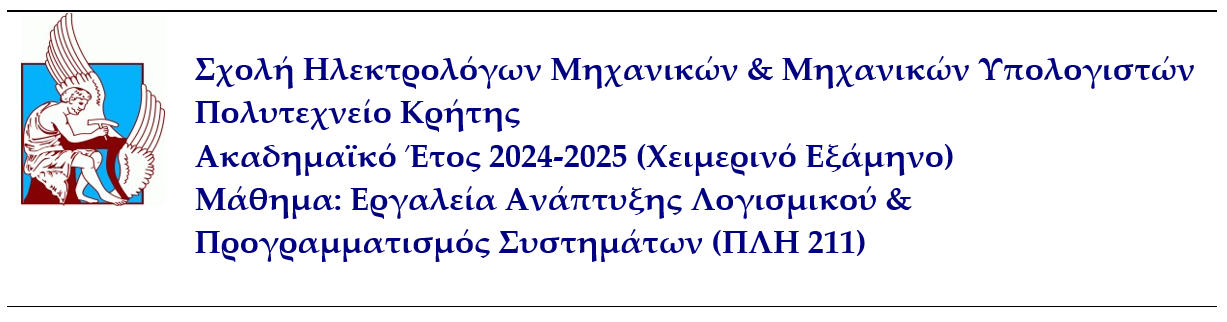

Aggregative Smart-Factory Robot Analyzer

# Development Phase

## ⏩ Κώδικας Development Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που υλοποιεί τον Aggregative Smart-Factory Robot Analyzer σας.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%file Analyzer.py
import csv
import os
import math


class Robot:
  def __init__(self, robotID):
    self.__robotID = robotID
    self.__times = []
    self.__positions = []  # list of (px, py, pz) tuples
    self.__speeds = []     # list of (vx, vy) tuples
    self.__goal_statuses = []
    self.__idle_flags = []
    self.__linear_flags = []
    self.__rotational_flags = []
    self.__deadlock_flags = []
    self.__contact_flags = []


  def add_data_point(self, time, px, py, pz, vx, vy, goal_status, idle, linear, rotational, deadlock, body_contact):
    # Method to add data point for a specific robot.
    self.__times.append(time)
    self.__positions.append((px, py, pz))
    self.__speeds.append((vx, vy))
    self.__goal_statuses.append(goal_status)
    self.__idle_flags.append(idle)
    self.__linear_flags.append(linear)
    self.__rotational_flags.append(rotational)
    self.__deadlock_flags.append(deadlock)
    self.__contact_flags.append(body_contact)

  @property
  def positions(self):
    return self.__positions # changed here

  @property
  def speeds(self):
    return self.__speeds

  @property
  def idle_flags(self):
    return self.__idle_flags

  @property
  def times(self):
    return self.__times

  @property
  def goal_statuses(self):
    return self.__goal_statuses

  @property
  def deadlock_flags(self):
    return self.__deadlock_flags




class RobotManager:
  __manager_instance = None

  def __init__(self):
    self.__robots = {} # In this dictionary: key = robot_id, value = Robot instance

  @staticmethod
  def get_robot_manager():
    if RobotManager.__manager_instance is None:
      RobotManager.__manager_instance = RobotManager()
    return RobotManager.__manager_instance

  def created(self, robotID):
    return robotID in self.__robots


  def read_csv(self, filename, max_rows):
    with open(filename, mode='r') as data:
      reader = csv.reader(data)
      headers = next(reader)

      for i, row in enumerate(reader):

        if max_rows and i>=max_rows:
          # if max rows = 0 or none then it will read all the data in the csv given.
          break

        robotID = int(row[0])
        if not self.created(robotID):
          self.__robots[robotID] = Robot(robotID)

        self.__robots[robotID].add_data_point(
            time = float(row[1]),
            px = float(row[3]),
            py = float(row[4]),
            pz = float(row[5]),
            vx = float(row[6]),
            vy = float(row[7]),
            goal_status = row[8],
            idle = self.to_boolean(row[9]),
            linear = self.to_boolean(row[10]),
            rotational = self.to_boolean(row[11]),
            deadlock = self.to_boolean(row[12]),
            body_contact = self.to_boolean(row[13])
            )


  def get_robot(self, robotID):
    # Returns None in case robot with the specific ID does not exist.
    return self.__robots.get(robotID)

  def read_csv_per_robot(self, filename, max_rows_per_robot, max_total_rows=0):

      per_robot_counts = {}

      with open(filename, mode='r') as data:
          reader = csv.reader(data)
          headers = next(reader)

          for i, row in enumerate(reader):
              if max_total_rows and i >= max_total_rows:
                  break

              robotID = int(row[0])


              current_count = per_robot_counts.get(robotID, 0)
              if current_count >= max_rows_per_robot:
                  # Ήδη έχουμε αρκετά για αυτό το robot → skip
                  continue

              if not self.created(robotID):
                  self.__robots[robotID] = Robot(robotID)

              self.__robots[robotID].add_data_point(
                  time=float(row[1]),
                  px=float(row[3]),
                  py=float(row[4]),
                  pz=float(row[5]),
                  vx=float(row[6]),
                  vy=float(row[7]),
                  goal_status=row[8],
                  idle=self.to_boolean(row[9]),
                  linear=self.to_boolean(row[10]),
                  rotational=self.to_boolean(row[11]),
                  deadlock=self.to_boolean(row[12]),
                  body_contact=self.to_boolean(row[13])
              )

              per_robot_counts[robotID] = current_count + 1

  @property
  def robots(self):
      return self.__robots


  @staticmethod
  def to_boolean(value):
    return value.strip().lower() == 'true'


  def run_analysis(self, strategy, **kwargs):
      return strategy.analyze(self.__robots, **kwargs)





  ##########################################################################################################################







# Right below there live analysis stategies.

# Analysis Helper classes

class AnalysisStrategy:
  def analyze(self, robots, **kwargs):
      """
      All analysis classes must implement analyze method.

      """
      pass







class AvgSpeedBase():
  @staticmethod
  def compute_avg(robots):
    """
    Calculates average for each robot and returns a dict with key -> robot id.
    Returns results: dict -> {key = id, value: average}.

    """
    results = {}
    for id, robot in robots.items():
      if not robot.speeds:
        continue
      magnitudes = [((vx**2) + (vy**2)) ** 0.5 for vx, vy in robot.speeds]
      avg_speed = sum(magnitudes) / len(magnitudes)
      results[id] = avg_speed
    return results # Note: Στο refactoring δεν θα επιστρεφει results αλλα θα γράφει σε csv το αποτέλεσμα --> πιο γρήγορο

  @staticmethod
  def compute_top_speed(robots, K):
    """
    Calculates top average speed using compute_avg and stores it in a list of tuples

    """
    averages = AvgSpeedBase.compute_avg(robots)
    data = [(id, avg, len(robots[id].speeds)) for id, avg in averages.items()]
    data.sort(key=lambda x: x[1], reverse = True)
    return data[:K]







class IdleRatioBase():
  @staticmethod
  def compute_idle_ratio(robots):
    """
    Calculates the idle ratio between MIN and MAX percentage

    """
    results = {}
    for id, robot in robots.items():
      if not robot.idle_flags:
        continue
      number_of_flags = len(robot.idle_flags)
      idle_true = sum(1 for b in robot.idle_flags if b)
      idle_ratio = idle_true / number_of_flags
      results[id] = idle_ratio
    return results







class CollisionsBase():
  """
  This class is responsible for implementing collisions T1 T2 method
  Returns result: Dictionary with key = id, value = collisions (list with times a collision happened for the specific robot)

  """
  @staticmethod
  def compute_collisions(robots):
    results = {}
    for id, robot in robots.items():
      times = robot.times
      statuses = robot.goal_statuses
      collisions = [t for t, s in zip(times, statuses)if "collision" in s.lower()]
      results[id] = collisions
    return results



class IcebergBase():

  @staticmethod
  def compute_displacement(robot):
    displacements =[]
    positions = robot.positions
    idle_flags = robot.idle_flags

    if not positions or not idle_flags or len(positions) != len(idle_flags):
      return displacements

    for i in range (1, len(positions)):
      if not idle_flags[i] and not idle_flags[i-1]:
        px1, py1, pz1 = positions[i-1]
        px2, py2, pz2 = positions[i]
        disp = ((px2-px1)**2 + (py2-py1)**2 + (pz2-pz1)**2)**0.5
        displacements.append(disp)

    return displacements






#-----------analysis classes-----------------



class AvgSpeedAnalysis(AnalysisStrategy):
    """
    This class is responsible for implementing avg_speed V1 V2 method.

    """
    def analyze(self, robots, **kwargs):
        v1 = kwargs.get("v1", 0) # Note: Second argument .get("v1", 0) -> default value for value.
        v2 = kwargs.get("v2", 10)
        robot_averages = AvgSpeedBase.compute_avg(robots)
        results = {}
        for id, average in robot_averages.items():
            if average > v1 and average <= v2:
                results[id] = {
                    "avg_speed" : average,
                    "samples" : len(robots[id].speeds)
                }

        return results


class Top_speed_analysis(AnalysisStrategy):
  """
  This class is resposible for implementing top_speed K method.

  """
  def analyze(self, robots, **kwargs):
      K = kwargs.get("k", 5)
      top_K = AvgSpeedBase.compute_top_speed(robots, K)
      results = {}
      for rank, (robot_id, avg_speed, n_samples) in enumerate(top_K, start=1):
        results[robot_id] = {
          "rank": rank,
          "avg_speed": avg_speed,
          "samples": n_samples
        }
      return results


class Idle_ratio_analysis(AnalysisStrategy):
  """
  This class is responsible for implementing idle_ratio MIN MAX method.

  """
  def analyze(self, robots, **kwargs):
    MIN = kwargs.get("MIN", 0.2)
    MAX = kwargs.get("MAX", float("inf"))
    idle_ratio = IdleRatioBase.compute_idle_ratio(robots)
    results = {}
    for id, ratio in idle_ratio.items():
      if ratio >= MIN and ratio <= MAX:
        results[id] = {
            "idle_ratio" : ratio,
            "samples" : len(robots[id].idle_flags)
        }

    return results


class CollisionsAnalysis(AnalysisStrategy):

  def analyze(self, robots, **kwargs):
    T1 = kwargs.get("T1", 0)
    T2 = kwargs.get("T2", float("inf"))
    collisions = CollisionsBase.compute_collisions(robots)
    results = {}
    for id, times in collisions.items():
      count = sum(T1 <= t <= T2 for t in times)
      if count > 0:
        results[id] = {
            "count" : count,
            "T1" : T1,
            "T2" : T2
        }
    return results




class DeadlockAnalysis(AnalysisStrategy):

  def analyze(self, robots, **kwargs):
    w = kwargs.get("W", 5)
    results = {}
    for id, robot in robots.items():
      flags = robot.deadlock_flags
      times = robot.times
      runs = []
      start_index = None
      run_len = 0

      for i, flag in enumerate(flags):
        if flag:
          if start_index is None:
            start_index = i
            run_len = 1
          else:
            run_len += 1
        else:
          if start_index is not None and run_len >= w:
            runs.append({

                        "id" : id,
                        "start" : times[start_index],
                        "end" : times[i - 1],
                        "len" : run_len

            })
          start_index = None
          run_len = 0

       # Handle last row
      if start_index is not None and run_len >= w:
        runs.append({

                      "id" : id,
                      "start" : times[start_index],
                      "end"  : times[-1],
                      "len" : run_len

        })

      if runs:
        results[id] = runs

    return results


class DominanceAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    avg_analysis = AvgSpeedBase.compute_avg(robots)
    idle_analysis = IdleRatioBase.compute_idle_ratio(robots)
    collision_analysis = CollisionsBase.compute_collisions(robots)

    collision_counts = {rid: len(c_list) for rid, c_list in collision_analysis.items()}

    dominance_points = {rid: 0 for rid in robots.keys()}

    robot_ids = list(robots.keys())

    for i in range(len(robot_ids)):
      for j in range(len(robot_ids)):
        if i == j:
          continue
        A = robot_ids[i]
        B = robot_ids[j]

        if avg_analysis[A] >= avg_analysis[B] and idle_analysis[A] <= idle_analysis[B] and collision_analysis[A] <= collision_analysis[B]:
          dominance_points[A] += 1

    results = {
      rid : {
        "avg_speed" : round(avg_analysis[rid], 4),
        "idle_ratio" : round(idle_analysis[rid], 3),
        "collisions" : len(collision_analysis[rid]),
        "dominance_points" : dominance_points[rid]
      }
      for rid in robots.keys()
    }

    results = dict(sorted(results.items(), key= lambda x: x[1]["dominance_points"], reverse=True))

    return results


class IcebergAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    K = kwargs.get("K", 100)
    S = kwargs.get("S", 0.8)
    results = {}

    for id, robot in robots.items():
      disps = IcebergBase.compute_displacement(robot)
      samples = len(disps)
      idle_flags = robot.idle_flags
      n_active = sum(not f for f in idle_flags)


      if samples >= K:
        if samples > 0:
          avg_disp = sum(disps)/samples
        else:
          avg_disp = 0

        if avg_disp > S:
          results[id] = {
              "mean displacement" : avg_disp,
              "number of samples" : samples
          }
    return results






"""
class IcebergAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    K = kwargs.get("K", 100)
    S = kwargs.get("S", 0.8)
    results = {}

    for rid, robot in robots.items():
      flags = robot.idle_flags
      positions = robot.positions


      runs, current = [], []
      for i, idle in enumerate(flags):
        if not idle:
          current.append(positions[i])
        else:
          if len(current) >= K:
            runs.append(current)
          current = []
      if len(current) >= K:
        runs.append(current)


      total_steps = 0
      total_disp_sum = 0.0
      for run in runs:

        for i in range(1, len(run)):
          dx = run[i][0] - run[i-1][0]
          dy = run[i][1] - run[i-1][1]
          dz = run[i][2] - run[i-1][2]
          total_disp_sum += (dx*dx + dy*dy + dz*dz) ** 0.5
        total_steps += max(0, len(run) - 1)


      if total_steps > 0:
        mean_disp = total_disp_sum / total_steps
        if mean_disp >= S:
          results[rid] = {
            "mean_displacement": round(mean_disp, 6),
            "records": total_steps,
            "segments": len(runs)
          }

    return results
"""





class CosineSimilarityAnalysis(AnalysisStrategy):

  @staticmethod
  def compute_cosine_similarity(a_speeds, b_speeds):
    nominator = 0
    magnitude_a = 0
    magnitude_b = 0

    for (vxa, vya), (vxb, vyb) in zip(a_speeds, b_speeds):
      nominator += (vxa*vxb + vya*vyb)
      magnitude_a += vxa**2 + vya**2
      magnitude_b += vxb**2 + vyb**2

    if magnitude_a == 0 or magnitude_b == 0:
      return 0

    return (nominator) / (math.sqrt(magnitude_a * magnitude_b))


  def analyze(self, robots, **kwargs):
    THETA = kwargs.get("THETA", 0.03)
    results = []
    robot_ids = list(robots.keys())
    for i in range(len(robot_ids)):
      for j in range(i + 1, len(robot_ids)):
        ida, idb = robot_ids[i], robot_ids[j]
        robota, robotb = robots[ida], robots[idb]
        similarity_result = CosineSimilarityAnalysis.compute_cosine_similarity(robota.speeds, robotb.speeds)
        #print(f"({ida}, {idb}) -> {round(similarity_result, 3)}")
        if abs(similarity_result) >= THETA:
          results.append({
                "robot_1" : ida,
                "robot_2" : idb,
                "cosine_similarity" : round(abs(similarity_result), 4)
          })

    results.sort(key=lambda x: x["cosine_similarity"], reverse=True)
    ##print(f"\nTotal pairs above threshold: {len(results)}\n")
    return results




class ProximityAnalysis(AnalysisStrategy):

  @staticmethod
  def calculate_distance(pos_a, pos_b):
    pxa, pya, pza = pos_a
    pxb, pyb, pzb = pos_b
    return math.sqrt((pxa-pxb)**2 + (pya - pyb)**2 + (pza - pzb)**2)


  def analyze(self, robots, **kwargs):
    D = kwargs.get("D", 0.1)
    results = []
    robot_ids = list(robots.keys())
    for i in range(len(robot_ids)):
      for j in range(i+1, len(robot_ids)):
        ida = robot_ids[i]
        idb = robot_ids[j]
        robota = robots[ida]
        robotb = robots[idb]
        positionsa = robots[ida].positions
        positionsb = robots[idb].positions


        n = min(len(positionsa), len(positionsb))
        for k in range(1, n):
          distance = ProximityAnalysis.calculate_distance(positionsa[k], positionsb[k])

          if distance < D:
            results.append({
                    "time" : min(robota.times[k], robotb.times[k]),
                    "robot1" : ida,
                    "robot2" : idb,
                    "distance" : distance
            })
    results.sort(key=lambda x: x["time"])
    #print(f"\nTotal proximity events (distance < {D}): {len(results)}\n")
    return results










































#----------------------------------------------------------------------------------------------------------------

from tabulate import tabulate

class OutputManager:
    @staticmethod
    def display_results(results, title="Results"):
        print(f"\n----- {title} -----")

        if not results:
            print(" No results found !")
            return


        if isinstance(results, dict):
            first_value = next(iter(results.values()))
            if isinstance(first_value, dict):
                headers = ["robotID"] + list(first_value.keys())
                table = []

                for rid, data in results.items():
                    table.append([rid] + list(data.values()))

                print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))
            elif isinstance(first_value, list):
                headers = ["robotID", "Έναρξη", "Λήξη", "Μήκος"]
                table = []

                for rid, runs in results.items():
                    for run in runs:
                        table.append([rid, run["start"], run["end"], run["len"]])

                print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))
            else:
                print(results)


        elif isinstance(results, list) and all(isinstance(x, dict) for x in results):
            headers = list(results[0].keys())
            table = [list(r.values()) for r in results]
            print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))

        else:
            print(results)

        print("\n")







class CLI:

  analyses = {

      "1": {
          "name" : "Average Speed Analysis",
          "class" : AvgSpeedAnalysis,
          "params" : [("v1", float, 0), ("v2", float, 10)]
      },
      "2" : {
          "name" : "Top Speed Analysis",
          "class" : Top_speed_analysis,
          "params" : [("k", int, 5)]
      },
      "3" : {
          "name" : "Idle Ratio Analysis",
          "class" : Idle_ratio_analysis,
          "params" : [("MIN", float, 0.2), ("MAX", float, float("inf"))]
      },
      "4" : {
          "name" : "Collisions Analysis",
          "class" : CollisionsAnalysis,
          "params" : [("T1", float, 0), ("T2", float, float("inf"))]
      },
      "5" : {

             "name": "Deadlock Analysis",
             "class" : DeadlockAnalysis,
             "params" : [("W", int, 5)]
      },
      "6" : {

             "name": "Dominance Analysis",
             "class" : DominanceAnalysis,
             "params" : []
      },
      "7": {
          "name": "Iceberg Analysis",
          "class": IcebergAnalysis,
          "params": [("K", int, 100), ("S", float, 0.8)]
      },
      "8": {
          "name": "Cosine Similarity Analysis",
          "class": CosineSimilarityAnalysis,
          "params": [("THETA", float, 0.03)]
      },
      "9": {
          "name": "Proximity Analysis",
          "class": ProximityAnalysis,
          "params": [("D", float, 0.1)]
      }
  }

  @staticmethod
  def run(filename : str):
    manager = RobotManager.get_robot_manager()
    manager.read_csv(filename, 0)

    while True:
      print("\n Choose an analysis : ")
      for key, info in CLI.analyses.items():
        print(f"{key}. {info['name']}")

      print("0. Exit")

      choice = input(">>> ")
      if choice == "0":
        break

      if choice not in CLI.analyses:
        print("\nInvalid Choice!")
        continue

      info = CLI.analyses[choice]
      kwargs = {}

      for param_name, ptype, default in info['params']:
        val = input(f"{param_name} (default={default}) >>>").strip()
        try:
          kwargs[param_name] = ptype(val) if val else default
        except ValueError:
          print(f"Invalid value for {param_name}, which uses default: {default}")
          kwargs[param_name] = default

      analysis_instance = info['class']()
      results = manager.run_analysis(analysis_instance, **kwargs)
      OutputManager.display_results(results, info['name'])






if __name__ == "__main__":
  #CLI.run("robots_subset.csv")
  #CLI.run("smart_factory_robots.csv")
  CLI.run("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv")
  #CLI.run("/content/drive/MyDrive/giatrakos_ergaleia/smart_factory_robots.csv")






Writing Analyzer.py


In [ ]:
!python Analyzer.py


 Choose an analysis : 
1. Average Speed Analysis
2. Top Speed Analysis
3. Idle Ratio Analysis
4. Collisions Analysis
5. Deadlock Analysis
6. Dominance Analysis
7. Iceberg Analysis
8. Cosine Similarity Analysis
9. Proximity Analysis
0. Exit
>>> 9
D (default=0.1) >>>

----- Proximity Analysis -----
|     time |   robot1 |   robot2 |   distance |
|----------|----------|----------|------------|
|    0.100 |        0 |       44 |      0.079 |
|    0.100 |        0 |       79 |      0.078 |
|    0.100 |        1 |       26 |      0.007 |
|    0.100 |        1 |       74 |      0.081 |
|    0.100 |        2 |       36 |      0.016 |
|    0.100 |        3 |       46 |      0.010 |
|    0.100 |        3 |       76 |      0.088 |
|    0.100 |        3 |       84 |      0.055 |
|    0.100 |        4 |        8 |      0.039 |
|    0.100 |        4 |       14 |      0.021 |
|    0.100 |        4 |       17 |      0.099 |
|    0.100 |        4 |       20 |      0.036 |
|    0.100 |        4 |      

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Developement Phase


Στην φάση ανάπτυξης υλοποιήσαμε μία καθαρά αντικειμενοστραφή αρχιτεκτονική. Η κλάση Robot κάνει encapsulate όλα τα δεδομένα ενός Robot με private variables, ενώ ο RobotManager διαχειρίζεται όλα τα robots σε ένα dictionary και είναι υλοποιημένος ως Singleton. Έτσι, διασφαλίζουμε ότι υπάρχει ένα μοναδικό σημείο που φορτώνονται και προσπελαύονται τα δεδομένα.

Οι αναλύσεις υλοποιούνται με Strategy design pattern. Υπάρχει μία abstract κλάση AnalysisStrategy με μία μέθοδο analyze(self, robots, **kwargs) και κάθε συγκεκριμένη ανάλυση κληρονομεί από αυτήν και υλοποιεί την δική της στρατηγική. Στον RobotManager βρίσκεται μία μέθοδος run_analysis(strategy, **kwargs) η οποία καλεί strategy_analyze(..) πάνω στο δοσμένο dictionary που είναι αποθηκευμένα τα Robots.

H χρήση των **kwargs ήταν ιδιαίτερα χρήσιμη. Επιτρέπει σε κάθε ανάλυση να δέχεται διαφορετικές παραμέτρους με το ίδιο interface, χωρίς να αλλάζει η run_analysis. Με αυτόν τον τρόπο, καθιστούμε εύκολη την προσθήκη οποιασδήποτε καινούριας ανάλυσης.

Η κλάση Robot περιέχει μία μέθοδο add_data_point(...) η οποία λειτουργεί ως μοναδικό api εισόδου για τα δεδομένα ενός Robot. Αυτό κάνει τον κώδικα μέσα στην read_csv() ευανάγνωστο αλλά και διασφαλίζουμε ότι όλη η δημιουργία και εξέλιξη της κατάστασης ενός Robot “περνάει” από ένα σημείο.

Τέλος, φτάξαμε μία κλάση CLI που είναι υπεύθυνη για το interaction με τον χρήστη ενώ φτιάξαμε και την OutputManager που είναι υπεύθυνη για την μορφοποίηση των αποτελεσμάτων σε πίνακες. Με αυτόν τον τρόπο διασφαλίσαμε ότι ο υπολογιστικός πυρήνας του κώδικα μας (Robot, Manager, Analyses) παραμένει ανεξάρτητος από το UI (ο θεός να το κάνει).

# Logging Phase


## ⏩ Κώδικας Logging Phase


In [ ]:

%%file logconfiguration.yaml
## you can also use .yaml instead
## your configuration goes here

version: 1
disable_existing_loggers: False

formatters:
  simple:
    #-%(lineno)d represent the line in the source code-
    format: "%(asctime)s - %(name)s - %(levelname)s - %(lineno)d - %(message)s"
    datefmt: "%Y-%m-%d %H:%M:%S"

handlers:
  console:
    class: logging.StreamHandler
    level: DEBUG
    formatter: simple
    stream: ext://sys.stdout

  file_handler:
    class: logging.FileHandler
    level: DEBUG
    formatter: simple
    filename: logme.txt
    mode: w

loggers:
  robot:
    level: DEBUG
    handlers: [file_handler]
    propagate: no

  analysis:
    level: DEBUG
    handlers: [file_handler]
    propagate: no

  compute:
    level: DEBUG
    handlers: [file_handler]
    propagate: no

  output:
    level: DEBUG
    handlers: [file_handler]
    propagate: no

#---root logger catches anything else not under the named loggers---
root:
  level: WARNING
  handlers: [console]

Overwriting logconfiguration.yaml


In [ ]:


import csv
import os
import math
import logging
import logging.config
import yaml

with open('logconfiguration.yaml', 'r') as f:
  config = yaml.safe_load(f.read())
  logging.config.dictConfig(config)

robot_logger = logging.getLogger('robot')
analysis_logger = logging.getLogger('analysis')
compute_logger = logging.getLogger('compute')
output_logger = logging.getLogger('output')


class Robot:
  def __init__(self, robotID):
    self.__robotID = robotID
    self.__times = []
    self.__positions = []  # list of (px, py, pz) tuples
    self.__speeds = []     # list of (vx, vy) tuples
    self.__goal_statuses = []
    self.__idle_flags = []
    self.__linear_flags = []
    self.__rotational_flags = []
    self.__deadlock_flags = []
    self.__contact_flags = []


  def add_data_point(self, time, px, py, pz, vx, vy, goal_status, idle, linear, rotational, deadlock, body_contact):
    # Method to add data point for a specific robot.
    self.__times.append(time)
    self.__positions.append((px, py, pz))
    self.__speeds.append((vx, vy))
    self.__goal_statuses.append(goal_status)
    self.__idle_flags.append(idle)
    self.__linear_flags.append(linear)
    self.__rotational_flags.append(rotational)
    self.__deadlock_flags.append(deadlock)
    self.__contact_flags.append(body_contact)

  @property
  def positions(self):
    return self.__positions # changed here

  @property
  def speeds(self):
    return self.__speeds

  @property
  def idle_flags(self):
    return self.__idle_flags

  @property
  def times(self):
    return self.__times

  @property
  def goal_statuses(self):
    return self.__goal_statuses

  @property
  def deadlock_flags(self):
    return self.__deadlock_flags




class RobotManager:
  __manager_instance = None

  def __init__(self):
    self.__robots = {} # In this dictionary: key = robot_id, value = Robot instance

  @staticmethod
  def get_robot_manager():
    if RobotManager.__manager_instance is None:
      RobotManager.__manager_instance = RobotManager()
    return RobotManager.__manager_instance

  def created(self, robotID):
    return robotID in self.__robots

  def read_csv(self, filename, max_rows):
    robot_logger.info(f"Reading data from file:{filename}") #-log-
    with open(filename, mode='r') as data:
      reader = csv.reader(data)
      headers = next(reader)
      robot_logger.debug(f"CSV headers:{headers}") #-log-

      for i, row in enumerate(reader):

        if max_rows and i>=max_rows:
          robot_logger.info(f"Reached max rows={max_rows}") #-log-
          # if max rows = 0 or none then it will read all the data in the csv given.
          break

        robotID = int(row[0])
        if not self.created(robotID):
          self.__robots[robotID] = Robot(robotID)
          robot_logger.debug(f"Created new robot instance: ID:{robotID}") #-log-

        self.__robots[robotID].add_data_point(
            time = float(row[1]),
            px = float(row[3]),
            py = float(row[4]),
            pz = float(row[5]),
            vx = float(row[6]),
            vy = float(row[7]),
            goal_status = row[8],
            idle = self.to_boolean(row[9]),
            linear = self.to_boolean(row[10]),
            rotational = self.to_boolean(row[11]),
            deadlock = self.to_boolean(row[12]),
            body_contact = self.to_boolean(row[13])
            )

    robot_logger.info(f"Successfully loaded {len(self.__robots)} robots from {filename}") #-log-
  def get_robot(self, robotID):
    # Returns None in case robot with the specific ID does not exist.
    return self.__robots.get(robotID)



  @property
  def robots(self):
      return self.__robots


  @staticmethod
  def to_boolean(value):
    return value.strip().lower() == 'true'


  def run_analysis(self, strategy, **kwargs):
      return strategy.analyze(self.__robots, **kwargs)





  ##########################################################################################################################







# Right below there live analysis stategies.

# Analysis Helper classes

class AnalysisStrategy:
  def analyze(self, robots, **kwargs):
      """
      All analysis classes must implement analyze method.

      """
      pass







class AvgSpeedBase():
  @staticmethod
  def compute_avg(robots):
    """
    Calculates average for each robot and returns a dict with key -> robot id.
    Returns results: dict -> {key = id, value: average}.

    """
    compute_logger.info("Starting Average Speed computation") #-log-
    results = {}
    for id, robot in robots.items():
      if not robot.speeds:
        compute_logger.warning(f"Robot {id} has no speed data, skipping") #-log-
        continue
      magnitudes = [((vx**2) + (vy**2)) ** 0.5 for vx, vy in robot.speeds]
      avg_speed = sum(magnitudes) / len(magnitudes)
      results[id] = avg_speed
    compute_logger.info(f"Computed average speeds for {len(results)} robots") #-log-
    return results # Note: Στο refactoring δεν θα επιστρεφει results αλλα θα γράφει σε csv το αποτέλεσμα --> πιο γρήγορο

  @staticmethod
  def compute_top_speed(robots, K):
    """
    Calculates top average speed using compute_avg and stores it in a list of tuples

    """
    compute_logger.info(f"Computing top {K} fastest robots") #-log-
    averages = AvgSpeedBase.compute_avg(robots)
    data = [(id, avg, len(robots[id].speeds)) for id, avg in averages.items()]
    data.sort(key=lambda x: x[1], reverse = True)
    compute_logger.debug(f"Computed {len(data[:K])} fastest robots") #-log-
    return data[:K]







class IdleRatioBase():
  @staticmethod
  def compute_idle_ratio(robots):
    """
    Calculates the idle ratio between MIN and MAX percentage

    """
    compute_logger.info("Starting idle ratio computation") #-log-
    results = {}
    for id, robot in robots.items():
      if not robot.idle_flags:
        compute_logger.warning(f"Robot {id} has no idle flags-skipping") #-log-
        continue
      number_of_flags = len(robot.idle_flags)
      idle_true = sum(1 for b in robot.idle_flags if b)
      idle_ratio = idle_true / number_of_flags
      results[id] = idle_ratio
    compute_logger.info(f"Computed idle ratio for {len(results)} robots") #-log-
    return results







class CollisionsBase():
  """
  This class is responsible for implementing collisions T1 T2 method
  Returns result: Dictionary with key = id, value = collisions (list with times a collision happened for the specific robot)

  """
  @staticmethod
  def compute_collisions(robots):
    compute_logger.info("Starting collision detection") #-log-
    results = {}
    for id, robot in robots.items():
      times = robot.times
      statuses = robot.goal_statuses
      if not times or not statuses:
        compute_logger.warning(f"Robot {id} has no time or status data") #-log-
      collisions = [t for t, s in zip(times, statuses)if "collision" in s.lower()]
      results[id] = collisions
    compute_logger.info(f"Collisions analysis complete for {len(results)} robots") #-log-
    return results



class IcebergBase():

  @staticmethod
  def compute_displacement(robot):
    compute_logger.info(f"Computing Displacement for Robot {robot.id}") #-log-
    displacements =[]
    positions = robot.positions
    idle_flags = robot.idle_flags

    if not positions or not idle_flags or len(positions) != len(idle_flags):
      compute.warning("Missing position or idle flag data") #-log-
      return displacements

    for i in range (1, len(positions)):
      if not idle_flags[i] and not idle_flags[i-1]:
        px1, py1, pz1 = positions[i-1]
        px2, py2, pz2 = positions[i]
        disp = ((px2-px1)**2 + (py2-py1)**2 + (pz2-pz1)**2)**0.5
        displacements.append(disp)
    compute_logger.debug(f"Computed {len(displacements)} displacements for robot {robot.id}") #-log-
    return displacements






#-----------analysis classes-----------------




class AvgSpeedAnalysis(AnalysisStrategy):
    """
    This class is responsible for implementing avg_speed V1 V2 method.

    """
    def analyze(self, robots, **kwargs):
        v1 = kwargs.get("v1", 0) # Note: Second argument .get("v1", 0) -> default value for value.
        v2 = kwargs.get("v2", 10)
        analysis_logger.info(f"Starting Average Speed Analysis with v1 = {v1}, v2 = {v2}") #-log-
        try:
          robot_averages = AvgSpeedBase.compute_avg(robots)
          results = {}
          for id, average in robot_averages.items():
              if average > v1 and average <= v2:
                  results[id] = {
                      "avg_speed" : average,
                      "samples" : len(robots[id].speeds)
                  }
          if not results:
            analysis_logger.warning("No robots matched the average speed criteria") #-log-
          analysis_logger.info(f"Average Speed Analysis complete: {len(results)} results") #-log-
          return results
        except Exception:
          analysis_logger.error("Error during Average Speed Analysis",exc_info=True) #-log-
          return {}


class Top_speed_analysis(AnalysisStrategy):
  """
  This class is resposible for implementing top_speed K method.

  """
  def analyze(self, robots, **kwargs):
      K = kwargs.get("k", 5)
      analysis_logger.info(f"Starting Top Speed Analysis with K = {K}") #-log-
      try:
        top_K = AvgSpeedBase.compute_top_speed(robots, K)
        results = {}
        for rank, (robot_id, avg_speed, n_samples) in enumerate(top_K, start=1):
          results[robot_id] = {
            "rank": rank,
            "avg_speed": avg_speed,
            "samples": n_samples
          }
        analysis_logger.info(f"Top Speed Analysis complete: {len(results)} entries") #-log-
        return results
      except Exception:
        analysis_logger.error("Top Speed Analysis failed", exc_info=True) #-log-
        return {}


class Idle_ratio_analysis(AnalysisStrategy):
  """
  This class is responsible for implementing idle_ratio MIN MAX method.

  """
  def analyze(self, robots, **kwargs):
    MIN = kwargs.get("MIN", 0.2)
    MAX = kwargs.get("MAX", float("inf"))
    analysis_logger.info(f"Starting Idle Ratio Analysis with MIN = {MIN}, MAX = {MAX}") #-log-
    try:
      idle_ratio = IdleRatioBase.compute_idle_ratio(robots)
      results = {}
      for id, ratio in idle_ratio.items():
        if ratio >= MIN and ratio <= MAX:
          results[id] = {
              "idle_ratio" : ratio,
              "samples" : len(robots[id].idle_flags)
          }
      if not results:
        analysis_logger.warning("No robots matched the idle ratio criteria")  # -log-

      analysis_logger.info(f"Idle Ratio Analysis completed: {len(results)} robots found")  # -log-
      return results
    except Exception:
      analysis_logger.error("Error during Idle Ratio Analysis", exc_info=True) #-log-
      return {}


class CollisionsAnalysis(AnalysisStrategy):

  def analyze(self, robots, **kwargs):
    T1 = kwargs.get("T1", 0)
    T2 = kwargs.get("T2", float("inf"))
    analysis_logger.info(f"Starting Collisions Analysis (T1={T1}, T2={T2})")  # -log-
    try:
      collisions = CollisionsBase.compute_collisions(robots)
      results = {}
      for id, times in collisions.items():
        count = sum(T1 <= t <= T2 for t in times)
        if count > 0:
          results[id] = {
              "count" : count,
              "T1" : T1,
              "T2" : T2
          }
      analysis_logger.info(f"Collision Analysis complete: {len(results)} robots with collisions")  # -log-
      if not results:
        analysis_logger.warning("No collisions detected in the given range")  # -log-
      return results
    except Exception:
      analysis_logger.error("Error in Collisions Analysis", exc_info=True) #-log-
      return {}




class DeadlockAnalysis(AnalysisStrategy):

  def analyze(self, robots, **kwargs):
    w = kwargs.get("W", 5)
    analysis_logger.info(f"Starting Deadlock Analysis (W={w})")  # -log-
    try:
      results = {}
      for id, robot in robots.items():
        flags = robot.deadlock_flags
        times = robot.times
        runs = []
        start_index = None
        run_len = 0

        for i, flag in enumerate(flags):
          if flag:
            if start_index is None:
              start_index = i
              run_len = 1
            else:
              run_len += 1
          else:
            if start_index is not None and run_len >= w:
              runs.append({

                          "id" : id,
                          "start" : times[start_index],
                          "end" : times[i - 1],
                          "len" : run_len

              })
            start_index = None
            run_len = 0

        # Handle last row
        if start_index is not None and run_len >= w:
          runs.append({

                        "id" : id,
                        "start" : times[start_index],
                        "end"  : times[-1],
                        "len" : run_len
          })

        if runs:
          results[id] = runs
      analysis_logger.info(f"deadlock Analysis completed: {len(results)} robots with deadlock") #-log-
      if not results:
        analysis_logger.warning("No deadlocks found")  # -log-
      return results
    except Exception:
      analysis_logger.error("Error during Deadlock Analysis", exc_info=True) #-log-
      return {}



class DominanceAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    analysis_logger.info("Starting Dominance Analysis")  # -log-
    try:
      avg_analysis = AvgSpeedBase.compute_avg(robots)
      idle_analysis = IdleRatioBase.compute_idle_ratio(robots)
      collision_analysis = CollisionsBase.compute_collisions(robots)
      analysis_logger.debug(f"Data gathered — avg speed:{len(avg_analysis)}, idle ratio:{len(idle_analysis)}, collisions:{len(collision_analysis)}")  # -log-

      collision_counts = {rid: len(c_list) for rid, c_list in collision_analysis.items()}

      dominance_points = {rid: 0 for rid in robots.keys()}

      robot_ids = list(robots.keys())

      for i in range(len(robot_ids)):
        for j in range(len(robot_ids)):
          if i == j:
            continue
          A = robot_ids[i]
          B = robot_ids[j]

          if avg_analysis[A] >= avg_analysis[B] and idle_analysis[A] <= idle_analysis[B] and collision_analysis[A] <= collision_analysis[B]:
            dominance_points[A] += 1

      results = {
        rid : {
          "avg_speed" : round(avg_analysis[rid], 4),
          "idle_ratio" : idle_analysis[rid],
          "collisions" : collision_analysis[rid],
          "dominance_points" : dominance_points[rid]
        }
        for rid in robots.keys()
      }

      results = dict(sorted(results.items(), key= lambda x: x[1]["dominance_points"], reverse=True))

      analysis_logger.info(f"Dominance Analysis complete: {len(results)} robots processed")  # -log-
      if not results:
        analysis_logger.warning("Dominance Analysis produced no results")  # -log-
      return results

    except Exception:
      analysis_logger.error("Error during Dominance Analysis", exc_info=True)  # -log-
      return {}


class IcebergAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    K = kwargs.get("K", 100)
    S = kwargs.get("S", 0.8)
    analysis_logger.info(f"Starting Iceberg Analysis (K={K}, S={S})")  # -log-
    try:
      results = {}

      for id, robot in robots.items():
        disps = IcebergBase.compute_displacement(robot)
        samples = len(disps)
        idle_flags = robot.idle_flags
        n_active = sum(not f for f in idle_flags)


        if samples >= K:
          if samples > 0:
            avg_disp = sum(disps)/samples
          else:
            avg_disp = 0

          if avg_disp > S:
            results[id] = {
                "mean displacement" : avg_disp,
                "number of samples" : samples
            }
      analysis_logger.info(f"Iceberg Analysis complete: {len(results)} robots above threshold")  # -log-
      if not results:
        analysis_logger.warning("No robots exceeded the iceberg threshold")  # -log-
      return results
    except Exception:
      analysis_logger.error("Error during Iceberg Analysis", exc_info=True) #-log-
      return {}




class CosineSimilarityAnalysis(AnalysisStrategy):

  @staticmethod
  def compute_cosine_similarity(a_speeds, b_speeds):
    compute_logger.info(f"Computing Cosine similarity")
    nominator = 0
    magnitude_a = 0
    magnitude_b = 0

    for (vxa, vya), (vxb, vyb) in zip(a_speeds, b_speeds):
      nominator += (vxa*vxb + vya*vyb)
      magnitude_a += vxa**2 + vya**2
      magnitude_b += vxb**2 + vyb**2

    if magnitude_a == 0 or magnitude_b == 0:
      analysis_logger.warning("one or both robots has no movement") #-log-
      return 0

    return (nominator) / (math.sqrt(magnitude_a * magnitude_b))


  def analyze(self, robots, **kwargs):
    THETA = kwargs.get("THETA", 0.03)
    analysis_logger.info(f"starting Cosine similarity Analysis with THETA={THETA}")  # -log-
    try:
      results = []
      robot_ids = list(robots.keys())
      for i in range(len(robot_ids)):
        for j in range(i + 1, len(robot_ids)):
          ida, idb = robot_ids[i], robot_ids[j]
          robota, robotb = robots[ida], robots[idb]
          similarity_result = CosineSimilarityAnalysis.compute_cosine_similarity(robota.speeds, robotb.speeds)
          print(f"({ida}, {idb}) -> {round(similarity_result, 3)}")
          if abs(similarity_result) >= THETA:
            results.append({
                  "robot_1" : ida,
                  "robot_2" : idb,
                  "cosine_similarity" : round(abs(similarity_result), 4)
            })

      results.sort(key=lambda x: x["cosine_similarity"], reverse=True)
      print(f"\nTotal pairs above threshold: {len(results)}\n")
      analysis_logger.info(f"Cosine Similarity complete: {len(results)} pairs above threshold: {THETA}")  # -log-
      if not results:
        analysis_logger.warning("No robot pairs exceeded cosine similarity threshold")  # -log-
      return results
    except Exception:
      analysis_logger.error("Error during Cosine Similarity Analysis", exc_info=True)  # -log-
      return {}




class ProximityAnalysis(AnalysisStrategy):

  @staticmethod
  def calculate_distance(pos_a, pos_b):
    compute_logger.info(f"Computing distance between pos1: {pos_a}, pos2: {pos_b}")
    pxa, pya, pza = pos_a
    pxb, pyb, pzb = pos_b
    return math.sqrt((pxa-pxb)**2 + (pya - pyb)**2 + (pza - pzb)**2)


  def analyze(self, robots, **kwargs):
    D = kwargs.get("D", 0.1)
    analysis_logger.info(f"Starting Proximity Analysis (D={D})")  # -log-
    try:
      results = []
      robot_ids = list(robots.keys())
      for i in range(len(robot_ids)):
        for j in range(i+1, len(robot_ids)):
          ida = robot_ids[i]
          idb = robot_ids[j]
          robota = robots[ida]
          robotb = robots[idb]
          positionsa = robots[ida].positions
          positionsb = robots[idb].positions


          n = min(len(positionsa), len(positionsb))
          for k in range(1, n):
            distance = ProximityAnalysis.calculate_distance(positionsa[k], positionsb[k])

            if distance < D:
              results.append({
                      "time" : min(robota.times[k], robotb.times[k]),
                      "robot1" : ida,
                      "robot2" : idb,
                      "distance" : distance
              })
      results.sort(key=lambda x: x["time"])
      print(f"\nTotal proximity events (distance < {D}): {len(results)}\n")
      analysis_logger.info(f"Proximity Analysis complete: {len(results)} proximity events found with D<{D}")  # -log-
      if not results:
        analysis_logger.warning("No proximity events detected")  # -log-
      analysis_logger.debug(f"Sample events: {results[:5]}")  # -log-
      return results
    except Exception:
      analysis_logger.error("Error during Proximity Analysis", exc_info=True)  # -log-
      return {}







#----------------------------------------------------------------------------------------------------------------

from tabulate import tabulate

class OutputManager:
    """
    Prints results in nicely aligned tables (matching professor’s format)
    """

    @staticmethod
    def display_results(results, title="Results"):
        output_logger.info(f"Displaying {title}") #-log-
        print(f"\n----- {title} -----")

        if not results:
            output_logger.warning(f"No results to display for '{title}'")  # -log-
            print(" No results found !")
            return

        # --- CASE 1: results is a dict ---
        if isinstance(results, dict):
            first_value = next(iter(results.values()))
            if isinstance(first_value, dict):
                # Each row is robot_id + dict values
                headers = ["robotID"] + list(first_value.keys())
                table = []
                for rid, data in results.items():
                    table.append([rid] + list(data.values()))
                output_logger.debug(f"Displaying {len(table)} rows for results in dictionary")  # -log-
                print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))
            elif isinstance(first_value, list):
                # Special case: e.g., DeadlockAnalysis (list of dicts per robot)
                headers = ["robotID", "Έναρξη", "Λήξη", "Μήκος"]
                table = []
                for rid, runs in results.items():
                    for run in runs:
                        table.append([rid, run["start"], run["end"], run["len"]])
                output_logger.debug(f"Displaying {len(table)} runs for results in list of dictionaries")  # -log-
                print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))
            else:
                output_logger.debug("Displayed raw dictionary values")  # -log-
                print(results)

        # --- CASE 2: results is a list (e.g., CosineSimilarity) ---
        elif isinstance(results, list) and all(isinstance(x, dict) for x in results):
            headers = list(results[0].keys())
            table = [list(r.values()) for r in results]
            output_logger.debug(f"Displaying {len(table)} results in list")  # -log-
            print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))

        # --- Fallback case ---
        else:
            output_logger.warning(f"Unsupported result type for {title}")  # -log-
            print(results)

        print("\n")
        output_logger.info(f"Finished displaying results for {title}")  # -log-









class CLI:

  analyses = {

      "1": {
          "name" : "Average Speed Analysis",
          "class" : AvgSpeedAnalysis,
          "params" : [("v1", float, 0), ("v2", float, 10)]
      },
      "2" : {
          "name" : "Top Speed Analysis",
          "class" : Top_speed_analysis,
          "params" : [("k", int, 5)]
      },
      "3" : {
          "name" : "Idle Ratio Analysis",
          "class" : Idle_ratio_analysis,
          "params" : [("MIN", float, 0.2), ("MAX", float, float("inf"))]
      },
      "4" : {
          "name" : "Collisions Analysis",
          "class" : CollisionsAnalysis,
          "params" : [("T1", float, 0), ("T2", float, float("inf"))]
      },
      "5" : {

             "name": "Deadlock Analysis",
             "class" : DeadlockAnalysis,
             "params" : [("W", int, 5)]
      },
      "6" : {

             "name": "Dominance Analysis",
             "class" : DominanceAnalysis,
             "params" : []
      },
      "7": {
          "name": "Iceberg Analysis",
          "class": IcebergAnalysis,
          "params": [("K", int, 100), ("S", float, 0.8)]
      },
      "8": {
          "name": "Cosine Similarity Analysis",
          "class": CosineSimilarityAnalysis,
          "params": [("THETA", float, 0.03)]
      },
      "9": {
          "name": "Proximity Analysis",
          "class": ProximityAnalysis,
          "params": [("D", float, 0.1)]
      }
  }

  @staticmethod
  def run(filename : str):
    output_logger.info(f"Initializing CLI and loading file {filename}")  # -log-
    try:
      manager = RobotManager.get_robot_manager()
      manager.read_csv(filename, 0)
    except Exception:
      output_logger.critical("Failed to load CSV data", exc_info=True) #-log-

    while True:
      print("\n Choose an analysis: ")
      for key, info in CLI.analyses.items():
        print(f"{key}. {info['name']}")

      print("0. Exit")

      choice = input(">>> ")
      if choice == "0":
        output_logger.info("User exited CLI") #-log-
        break

      if choice not in CLI.analyses:
        output_logger.warning(f"Invalid user choice: {choice}") #-log-
        print("\nInvalid Choice!")
        continue

      info = CLI.analyses[choice]
      output_logger.info(f"User selected: {info['name']}")  # -log-
      kwargs = {}

      for param_name, ptype, default in info['params']:
        val = input(f"{param_name} (default={default}>>> )").strip()
        try:
          kwargs[param_name] = ptype(val) if val else default
        except ValueError:
          output_logger.warning(f"Invalid input for {param_name}") #-log-
          print(f"Invalid value for {param_name}, which uses default: {default}")
          kwargs[param_name] = default

      analysis_instance = info['class']()
      results = manager.run_analysis(analysis_instance, **kwargs)
      output_logger.info(f"{info['name']} completed successfully")  # -log-
      OutputManager.display_results(results, info['name'])






if __name__ == "__main__":
  #CLI.run("robots_subset.csv")
  #CLI.run("smart_factory_robots.csv")
  CLI.run("all_robots_subset_25k.csv")








 Choose an analysis if you want to live: 
1. Average Speed Analysis
2. Top Speed Analysis
3. Idle Ratio Analysis
4. Collisions Analysis
5. Deadlock Analysis
7. Iceberg Analysis
8. Cosine Similarity Analysis
9. Proximity Analysis
0. Exit
>>> 3
MIN (default=0.2>>> )
MAX (default=inf>>> )

----- Idle Ratio Analysis -----
|   robotID |   idle_ratio |   samples |
|-----------|--------------|-----------|
|         0 |        0.504 |     25000 |
|         1 |        0.502 |     25000 |
|         2 |        0.502 |     25000 |
|         3 |        0.498 |     25000 |
|         4 |        0.500 |     25000 |
|         5 |        0.499 |     25000 |
|         6 |        0.500 |     25000 |
|         7 |        0.495 |     25000 |
|         8 |        0.496 |     25000 |
|         9 |        0.497 |     25000 |
|        10 |        0.500 |     25000 |
|        11 |        0.498 |     25000 |
|        12 |        0.503 |     25000 |
|        13 |        0.503 |     25000 |
|        14 |        0.

a

Στο παραπάνω σύστημα ανάλυσης δεδομένων ρομπότ, έχουμε υλοποιήσει την διαδικασία του logging με την χρήση yaml. Δημιουργήσαμε δύο handlers, έναν για output στην οθόνη και άλλον έναν πάνω σε αρχείο logme.txt, όπως αναγράφεται και στις οδηγίες. Χρησιμοποιήσαμε ένα μόνο είδος formatter, αυτόν που αναφέρεται στις οδηγίες και εμφανίζει την ημερομηνία καταγραφής, το όνομα του logger, το επίπεδο του μυνηματος, την γραμμή στην οποία είναι καταγεγραμμένο το μύνημα και το μύνημα. Παρόλο που μας δώθηκε το προτεινόμενο fromat για τους loggers, προτιμήσαμε να περιέχεται και η γραμμη στον κώδικα, διότι μασ βοήθησε παραπάνω στην εύρεση τυχόν λάθη ή κενά στον κώδικα. Επίσης δημιουργήσαμε 4 loggers, έναν για τον robot manager, έναν για τις analysis κλάσεις, έναν για τις helper κλάσεις των analysis(compute κλάσεις) και έναν υπεύθυνο για το CLI και output manager. Επίσης δημιουργήσαμε και έαν root logger, ο
οποίος "πιάνει" οτιδήποτε δεν ανήκει στους παραπάνω loggers, και εκτυπώνει τα logs του μονο στην κονσόλα, εάν το επίπεδο του μυνήματος είναι πάνω από warning.



# Profiling Phase - Part 1

## ⏩ Κώδικας Profiling Phase - Part 1

In [ ]:
!pip install memory-profiler requests
!pip install line-profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00


In [ ]:
%%file cprofile.py
import os
import cProfile, pstats
from Analyzer import (AvgSpeedAnalysis, Top_speed_analysis, Idle_ratio_analysis, CollisionsAnalysis, DeadlockAnalysis, DominanceAnalysis, IcebergAnalysis, CosineSimilarityAnalysis, ProximityAnalysis, RobotManager)


manager = RobotManager.get_robot_manager()
manager.read_csv("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv", 0)
#small_robots = {rid: manager.robots[rid] for rid in list(manager.robots.keys())[:100]}
#print(f"Using {len(small_robots)} robots for profiling.")


output_folder = "cprofile_report_1"
os.makedirs(output_folder, exist_ok=True)

analyses = [
    ("AvgSpeedAnalysis", AvgSpeedAnalysis(), {"v1": 0, "v2": 10}),
    ("TopSpeedAnalysis", Top_speed_analysis(), {"k": 5}),
    ("IdleRatioAnalysis", Idle_ratio_analysis(), {"MIN": 0.2, "MAX": 0.4}),
    ("CollisionsAnalysis", CollisionsAnalysis(), {"T1": 0, "T2": 200}),
    ("DeadlockAnalysis", DeadlockAnalysis(), {"W": 5}),
    ("DominanceAnalysis", DominanceAnalysis(), {}),
    ("IcebergAnalysis", IcebergAnalysis(), {"K": 100, "S": 0.8}),
    ("CosineSimilarityAnalysis", CosineSimilarityAnalysis(), {"THETA": 0.03}),
    ("ProximityAnalysis", ProximityAnalysis(), {"D": 0.1})
]

for name, analysis, params in analyses:
    print("\n====================================")
    print(f"---- Profiling {name} ----")
    print("====================================")

    report_path = os.path.join(output_folder, f"{name}_cprofile_report.txt")

    profiler = cProfile.Profile()
    profiler.enable()
    manager.run_analysis(analysis, **params)
    profiler.disable()

    with open(report_path, "w") as file:
        stats = pstats.Stats(profiler, stream=file)
        stats.strip_dirs().sort_stats("cumtime").print_stats(10)

    print(f"Saved report: {report_path}")


Overwriting cprofile.py


In [ ]:
!python cprofile.py

Using 100 robots for profiling.

---- Profiling AvgSpeedAnalysis ----
Saved report: cprofile_report_1/AvgSpeedAnalysis_cprofile_report.txt

---- Profiling TopSpeedAnalysis ----
Saved report: cprofile_report_1/TopSpeedAnalysis_cprofile_report.txt

---- Profiling IdleRatioAnalysis ----
Saved report: cprofile_report_1/IdleRatioAnalysis_cprofile_report.txt

---- Profiling CollisionsAnalysis ----
Saved report: cprofile_report_1/CollisionsAnalysis_cprofile_report.txt

---- Profiling DeadlockAnalysis ----
Saved report: cprofile_report_1/DeadlockAnalysis_cprofile_report.txt

---- Profiling DominanceAnalysis ----
Saved report: cprofile_report_1/DominanceAnalysis_cprofile_report.txt

---- Profiling IcebergAnalysis ----
Saved report: cprofile_report_1/IcebergAnalysis_cprofile_report.txt

---- Profiling CosineSimilarityAnalysis ----
Saved report: cprofile_report_1/CosineSimilarityAnalysis_cprofile_report.txt

---- Profiling ProximityAnalysis ----
Saved report: cprofile_report_1/ProximityAnalysis_c

In [ ]:
%%writefile robot_analyses.py
from line_profiler.explicit_profiler import profile

#### Here i bring the robot analyses we care to line profile



import math

class AnalysisStrategy:
  def analyze(self, robots, **kwargs):
      """
      All analysis classes must implement analyze method.

      """
      pass



class CosineSimilarityAnalysis(AnalysisStrategy):

  @staticmethod
  @profile
  def compute_cosine_similarity(a_speeds, b_speeds):
    nominator = 0
    magnitude_a = 0
    magnitude_b = 0

    for (vxa, vya), (vxb, vyb) in zip(a_speeds, b_speeds):
      nominator += (vxa*vxb + vya*vyb)

      magnitude_a += vxa**2 + vya**2
      magnitude_b += vxb**2 + vyb**2

      #magnitude_a += vxa*vxa + vya*vya
      #magnitude_b += vxb*vxb + vyb*vyb

    if magnitude_a == 0 or magnitude_b == 0:
      return 0

    return (nominator) / (math.sqrt(magnitude_a * magnitude_b))




  @profile
  def analyze(self, robots, **kwargs):
    THETA = kwargs.get("THETA", 0.03)
    results = []
    robot_ids = list(robots.keys())
    for i in range(len(robot_ids)):
      for j in range(i + 1, len(robot_ids)):
        ida, idb = robot_ids[i], robot_ids[j]
        robota, robotb = robots[ida], robots[idb]
        similarity_result = CosineSimilarityAnalysis.compute_cosine_similarity(robota.speeds, robotb.speeds)
        #print(f"({ida}, {idb}) -> {round(similarity_result, 3)}")
        if abs(similarity_result) >= THETA:
          results.append({
                "robot_1" : ida,
                "robot_2" : idb,
                "cosine_similarity" : round(abs(similarity_result), 4)
          })

    results.sort(key=lambda x: x["cosine_similarity"], reverse=True)
    ##print(f"\nTotal pairs above threshold: {len(results)}\n")
    return results







class ProximityAnalysis(AnalysisStrategy):

  @staticmethod
  @profile
  def calculate_distance(pos_a, pos_b):
    pxa, pya, pza = pos_a
    pxb, pyb, pzb = pos_b
    return math.sqrt((pxa-pxb)**2 + (pya - pyb)**2 + (pza - pzb)**2)

  @profile
  def analyze(self, robots, **kwargs):
    D = kwargs.get("D", 0.1)
    results = []
    robot_ids = list(robots.keys())
    for i in range(len(robot_ids)):
      for j in range(i+1, len(robot_ids)):
        ida = robot_ids[i]
        idb = robot_ids[j]
        robota = robots[ida]
        robotb = robots[idb]
        positionsa = robots[ida].positions
        positionsb = robots[idb].positions


        n = min(len(positionsa), len(positionsb))
        for k in range(n):
          distance = ProximityAnalysis.calculate_distance(positionsa[k], positionsb[k])

          if distance < D:
            results.append({
                    "time" : min(robota.times[k], robotb.times[k]),
                    "robot1" : ida,
                    "robot2" : idb,
                    "distance" : distance
            })
    results.sort(key=lambda x: x["time"])
    #print(f"\nTotal proximity events (distance < {D}): {len(results)}\n")
    return results


Overwriting robot_analyses.py


In [ ]:
from Analyzer import CosineSimilarityAnalysis, ProximityAnalysis, RobotManager
from line_profiler import LineProfiler

manager = RobotManager.get_robot_manager()
manager.read_csv_per_robot("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv", max_rows_per_robot=2)
robots_dict = manager.robots




#-------------------------- COSINE ---------------------
lp_cos = LineProfiler()
cosine = CosineSimilarityAnalysis()

lp_cos.add_function(cosine.compute_cosine_similarity)
lp_cos_wrapper = lp_cos(cosine.analyze)

lp_cos_wrapper(robots_dict, THETA=0.03)

lp_cos.print_stats()



Timer unit: 1e-09 s

Total time: 0.203258 s
File: /content/Analyzer.py
Function: CosineSimilarityAnalysis.compute_cosine_similarity at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                             @staticmethod
   547                                             def compute_cosine_similarity(a_speeds, b_speeds):
   548      4950    2977297.0    601.5      1.5      nominator = 0
   549      4950    2741627.0    553.9      1.3      magnitude_a = 0
   550      4950    2683835.0    542.2      1.3      magnitude_b = 0
   551                                           
   552     74250   49392431.0    665.2     24.3      for (vxa, vya), (vxb, vyb) in zip(a_speeds, b_speeds):
   553     69300   41278516.0    595.6     20.3        nominator += (vxa*vxb + vya*vyb)
   554     69300   47186181.0    680.9     23.2        magnitude_a += vxa**2 + vya**2
   555     69300   48188461.0    695.4     23.7        magnitude_b += vxb**2 + vyb**2
  

In [ ]:
from Analyzer import CosineSimilarityAnalysis, ProximityAnalysis, RobotManager
from line_profiler import LineProfiler

manager = RobotManager.get_robot_manager()
manager.read_csv_per_robot("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv", max_rows_per_robot=2)
robots_dict = manager.robots






# ---------------- PROXIMITY ----------------
lp_prox = LineProfiler()
proximity = ProximityAnalysis()

lp_prox.add_function(proximity.calculate_distance)
lp_prox_wrapper = lp_prox(proximity.analyze)

lp_prox_wrapper(robots_dict, D=0.1)

lp_prox.print_stats()

Using 100 robots for line profiling.
Timer unit: 1e-09 s

Total time: 0.246346 s
File: /content/Analyzer.py
Function: ProximityAnalysis.calculate_distance at line 589

Line #      Hits         Time  Per Hit   % Time  Line Contents
   589                                             @staticmethod
   590                                             def calculate_distance(pos_a, pos_b):
   591     59400   62170190.0   1046.6     25.2      pxa, pya, pza = pos_a
   592     59400   64985424.0   1094.0     26.4      pxb, pyb, pzb = pos_b
   593     59400  119190410.0   2006.6     48.4      return math.sqrt((pxa-pxb)**2 + (pya - pyb)**2 + (pza - pzb)**2)

Total time: 0.778414 s
File: /content/Analyzer.py
Function: ProximityAnalysis.analyze at line 596

Line #      Hits         Time  Per Hit   % Time  Line Contents
   596                                             def analyze(self, robots, **kwargs):
   597         1       2346.0   2346.0      0.0      D = kwargs.get("D", 0.1)
   598         1  

In [ ]:
%%file memory_analysis.py
from memory_profiler import profile
from Analyzer import (
    RobotManager,
    DeadlockAnalysis,
    DominanceAnalysis,
    CosineSimilarityAnalysis,
    ProximityAnalysis,
)

DATASET = "/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv"


@profile
def load_data(max_rows=0):
    manager = RobotManager.get_robot_manager()
    manager.read_csv(DATASET, max_rows)
    return manager


@profile
def run_deadlock(manager):
    manager.run_analysis(DeadlockAnalysis(), W=5)

@profile
def run_dominance(manager):
    manager.run_analysis(DominanceAnalysis())

@profile
def run_cosine(manager):
    manager.run_analysis(CosineSimilarityAnalysis(), THETA=0.03)

@profile
def run_proximity(manager):
    manager.run_analysis(ProximityAnalysis(), D=0.1)



if __name__ == "__main__":
  mgr = load_data(max_rows=500000)

  run_deadlock(mgr)
  run_dominance(mgr)
  run_cosine(mgr)
  run_proximity(mgr)



Overwriting memory_analysis.py


In [ ]:
!python -m memory_profiler memory_analysis.py > man_report_all.txt

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Profiling Phase - Part 1
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Profiling Phase - Part1  στα προηγούμενα code cell και **αναφέρατε τα συμπεράσματά σας για το που πρέπει να επικεντρωθεί το refactoring της επόμενης φάσης**.

Τα αποτελέσματα του profiling χρισημοποιόντας το cProfile module μας έδειξε ότι : 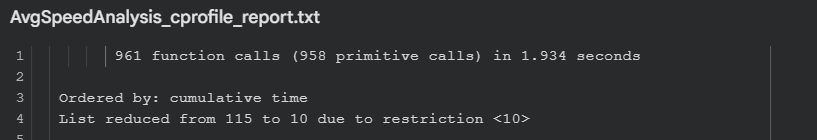 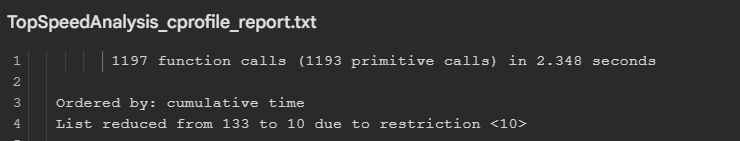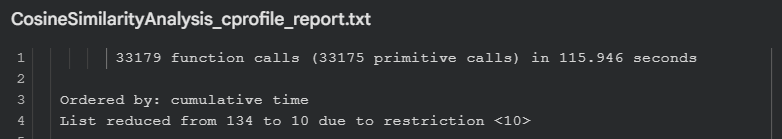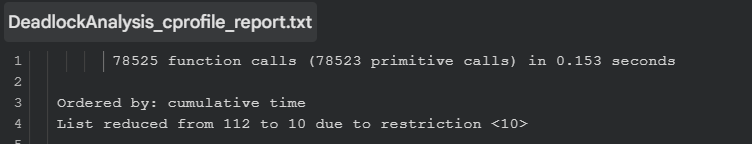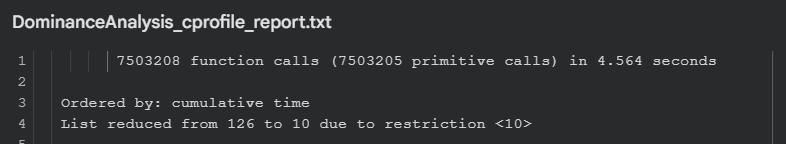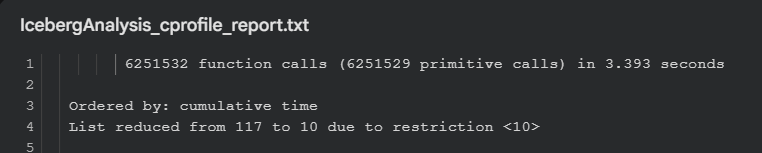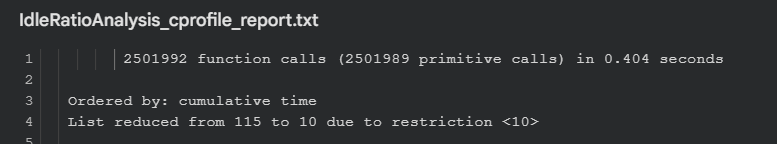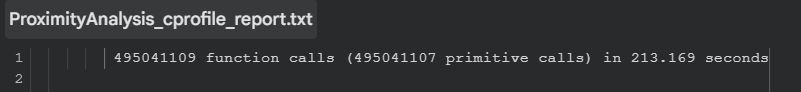 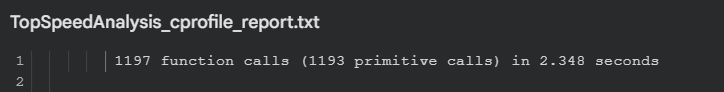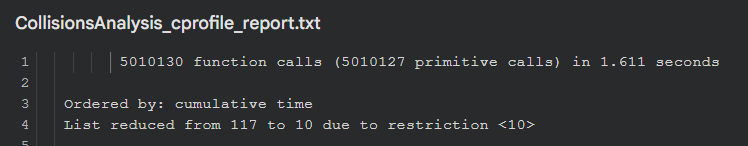

Στις παραπάνω φωτογραφίες βλέπουμε ότι οι αναλύσεις Proximity Analysis και Cosine Similarity Analysis είναι αυτές που απαιτούν τον περισσότερο χρόνο συγκριτικά με τις υπόλοιπες.

Cosine similarity: 116 seconds

Proximity: 213 seconds

Συνολικά οι υπόλοιπες συναρτήσεις έχουν ***μέσο όρο 2.05 seconds*** , ενώ η Proximity και η Cosine Similarity έχουν μέσο όρο ***164.5 seconds***. Με λίγα λόγια, η Proximity και η Cosine είναι ***80 φορές πιο αργές από τις υπόλοιπες αναλύσεις κατά μέσο όρο***. Αυτό σημαίνει ότι πρέπει να στρέψουμε την προσοχή μας σε αυτές τις δύο.


Σημαντική σημείωση

Οι μετρήσεις χρόνου πάρθηκαν πάνω σε subset των data, το οποίο αποτελείται από 25k records από τα 100k του κάθε Robot, δηλαδή και των 100 robot.

Χρησιμοποιήσαμε τον Line Profiler προκειμένου να αποκτήσουμε insight για το ποια μέρη του κώδικα των Proximity Analysis και Cosine Similarity Analysis καθυστερούν. Αναλύοντας το output του line profiler συμπεραίνουμε πως το bottleneck προκαλείται από τις helper συναρτήσεις compute_cosine_similarity και compute_distance.



Να σημειωθεί ότι σε Cosine Similarity και σε Proximity Analysis ***οι helper συναρτήσεις καταναλώνουν χρόνο με ποσοστά 90% και 70% αντίστοιχα.***


Οι μετρήσεις έγιναν με 100 robot με 2 εγγραφές το καθένα. Ο λόγος που επιλέχθηκε τόσο μικρό dataset είναι επειδή ο Line Profiler είναι πολύ πιο αργός του cProfiler εκ φύσεως και επειδή το νόημα στο line profiling είναι να αναγνωρίσουμε ποια γραμμή κώδικα στην ίδια ανάλυση παίρνει τον περισσότερο χρόνο. Ξέρουμε ήδη ότι αυτές οι αναλύσεις είναι οι πιο χρονοβόρες από τα πορίσματα του cProfiler, όπου έκει χρησιμοποιήθηκε επαρκώς μεγάλο dataset για να πάρουμε τις απαντήσεις που θέλαμε.

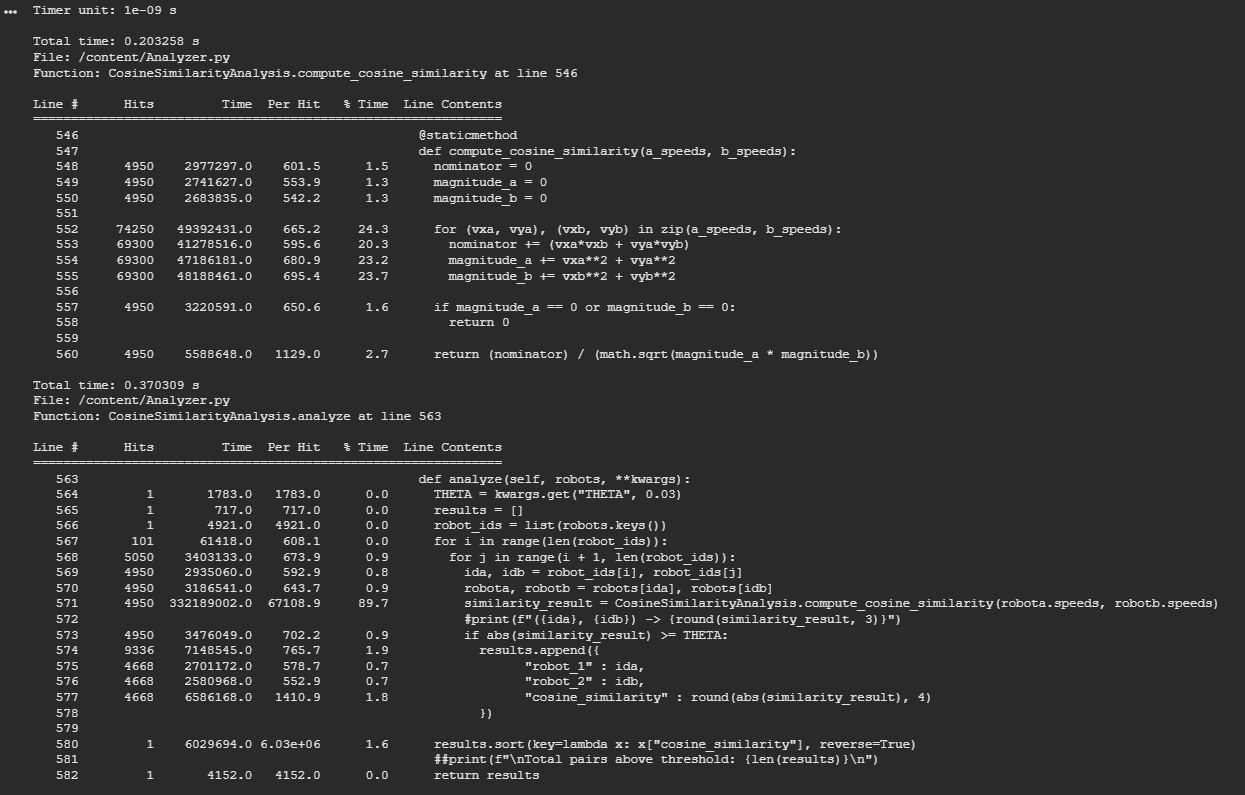


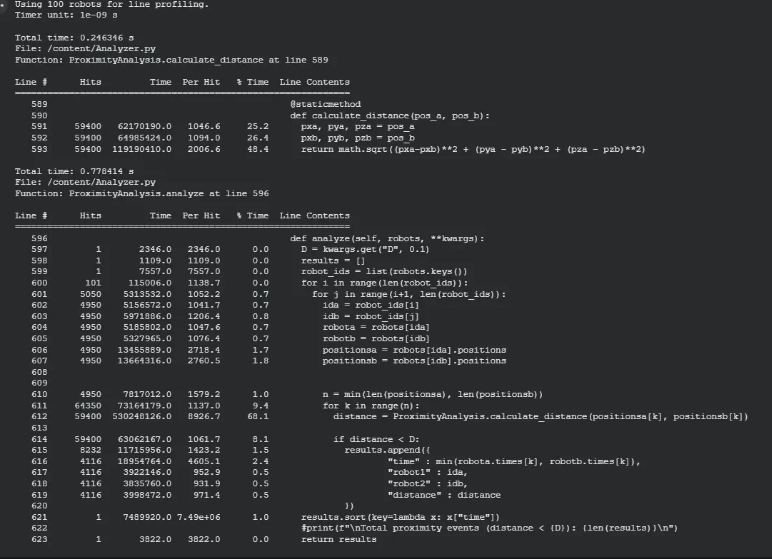

Τα αποτελέσματα του line_profiler επιβεβαίωσαν ότι τα περισσότερα bottlenecks οφείλονται σε διπλούς βρόχους σύγκρισης (O(N²)) (αναμενόμενο) μεταξύ όλων των ζευγών ρομπότ, καθώς και στη χρήση ακριβών μαθηματικών συναρτήσεων (math.sqrt, **2) μέσα σε εσωτερικά loops. Αυτό έχει ως αποτέλεσμα να αυξάνεται δραματικά ο χρόνος εκτέλεσης καθώς μεγαλώνει ο αριθμός των robots ή των samples.

Με βάση τα αποτελέσματα αποφασίζουμε να σπαταλήσουμε φαιά ουσία για το refactoring σε:

1) Μείωση περιττών πράξεων (επαναλαμβανόμενη χρήση math.sqrt())
2) Αποφυγή tuple unpacking
3) Αποφυγή υπολογισμού εκθετικών πράξεων (πχ. vx**2)

Προφανώς αφήνουμε ανοιχτά και άλλες πιθανές βελτιστοποιήσεις όπως εγγραφή σε αρχείο. Απλώς αυτές είναι οι πρώτες σκέψεις για το πως θα πορευτούμε στο refactoring.



Αποτελέσματα Memory Profiler



Από τα αποτελέσματα του Memory Profiler παρατηρούμε ότι η χρήση μνήμης μέσα σε σε κρίσημες συναρτήσεις δεν ανεβαίνει δραματικά μέσα στην εκτέλεση, αναμενόμενο διότι οι αναλύσεις δουλεύουν πάνω σε ήδη φορτωμένες λίστες και δεν δημιουργούν μεγάλες επιπλέον δομές. Υπάρχει μικρή αύξηση στην dominance και στην deadlocks αλλά προφανώς όχι κάτι συγκρίσιμο με την read_csv. Η βασική κατανάλωση μνήμης οφείλεται στο αρχικό data reading και στην αποθήκευση των δεδομένων σε Robot αντικείμενα. Με λίγα λόγια η μνήμη πηγαίνει στο μοντέλο δεδομένων, όχι στις αναλύσεις. Παρατηρούμε ότι το increment στην read_csv είναι στα 224 MiB, ενώ deadlock και dominance στα 1.4 MiB KAI 0.9 MiB αντίστοιχα. Δηλαδή η καταλνάλωση μνήμης στην read_csv είναι 268 φορές μεγαλύτερη από ότι στις potentially heavy αναλύσεις (deadlock, dominance).

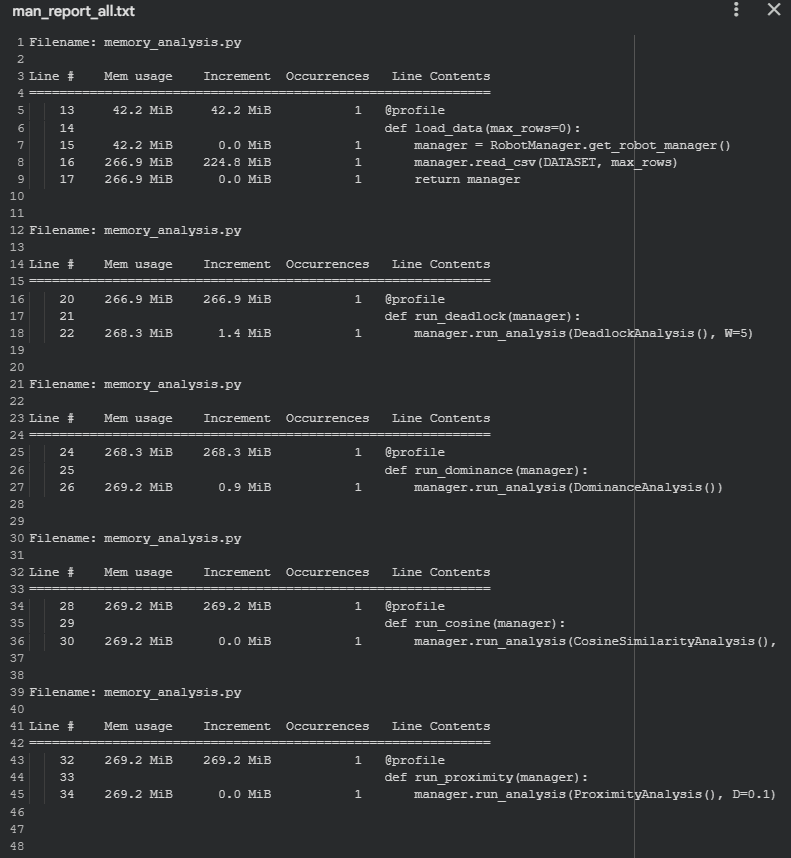

** Η ανάλυση για την μέτρηση της μνήμης έγινε με την χρήση των πρώων 500k rows.

Δίνονται συγκεντρωτικά οι πίνακες παρακάτω


cProfiler
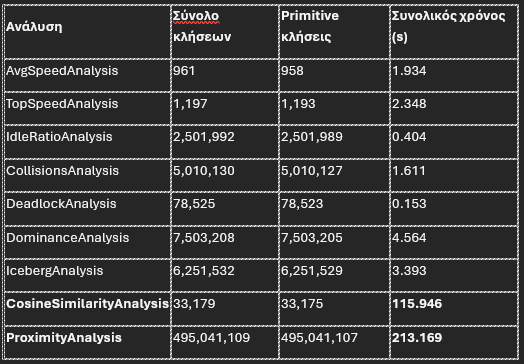

Line Profiler
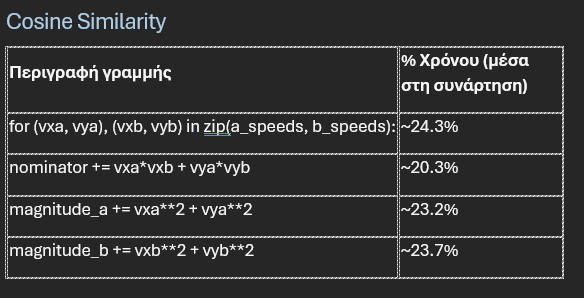

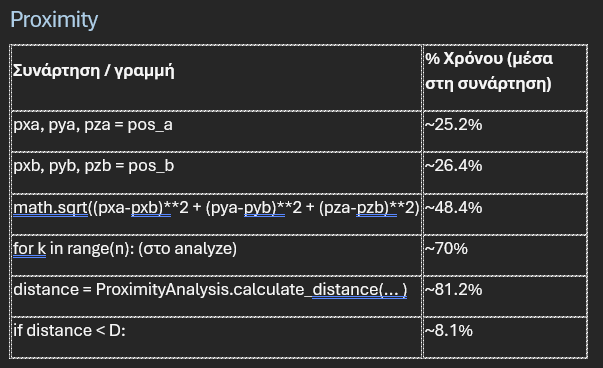


Memory Profiler
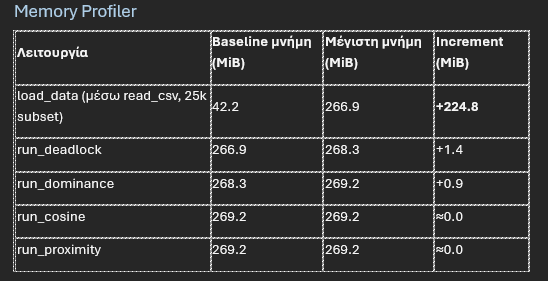

# Refactoring Phase

## ⏩ Κώδικας Refactoring Phase

In [ ]:
%%file RefactoredAnalyzer.py
import csv
import os
import math
import shutil #https://www.geeksforgeeks.org/python/delete-an-entire-directory-tree-using-python-shutil-rmtree-method/


CACHE_DIR = "cache"

if os.path.exists(CACHE_DIR):
  shutil.rmtree(CACHE_DIR)

os.makedirs(CACHE_DIR, exist_ok=True)

COSINE_CACHE_FILE = os.path.join(CACHE_DIR, "cosine_pairs.csv")

AVG_SPEED_CACHE = None


class Robot:
  def __init__(self, robotID):
    self.__robotID = robotID
    self.__times = []
    self.__positions = []  # list of (px, py, pz) tuples
    self.__speeds = []     # list of (vx, vy) tuples
    self.__goal_statuses = []
    self.__idle_flags = []
    self.__linear_flags = []
    self.__rotational_flags = []
    self.__deadlock_flags = []
    self.__contact_flags = []


  def add_data_point(self, time, px, py, pz, vx, vy, goal_status, idle, linear, rotational, deadlock, body_contact):
    # Method to add data point for a specific robot.
    self.__times.append(time)
    self.__positions.append((px, py, pz))
    self.__speeds.append((vx, vy))
    self.__goal_statuses.append(goal_status)
    self.__idle_flags.append(idle)
    self.__linear_flags.append(linear)
    self.__rotational_flags.append(rotational)
    self.__deadlock_flags.append(deadlock)
    self.__contact_flags.append(body_contact)

  @property
  def positions(self):
    return self.__positions # changed here

  @property
  def speeds(self):
    return self.__speeds

  @property
  def idle_flags(self):
    return self.__idle_flags

  @property
  def times(self):
    return self.__times

  @property
  def goal_statuses(self):
    return self.__goal_statuses

  @property
  def deadlock_flags(self):
    return self.__deadlock_flags




class RobotManager:
  __manager_instance = None

  def __init__(self):
    self.__robots = {} # In this dictionary: key = robot_id, value = Robot instance

  @staticmethod
  def get_robot_manager():
    if RobotManager.__manager_instance is None:
      RobotManager.__manager_instance = RobotManager()
    return RobotManager.__manager_instance

  def created(self, robotID):
    return robotID in self.__robots


  def read_csv(self, filename, max_rows):
    with open(filename, mode='r') as data:
      reader = csv.reader(data)
      headers = next(reader)

      for i, row in enumerate(reader):

        if max_rows and i>=max_rows:
          # if max rows = 0 or none then it will read all the data in the csv given.
          break

        robotID = int(row[0])
        if not self.created(robotID):
          self.__robots[robotID] = Robot(robotID)

        self.__robots[robotID].add_data_point(
            time = float(row[1]),
            px = float(row[3]),
            py = float(row[4]),
            pz = float(row[5]),
            vx = float(row[6]),
            vy = float(row[7]),
            goal_status = row[8],
            idle = self.to_boolean(row[9]),
            linear = self.to_boolean(row[10]),
            rotational = self.to_boolean(row[11]),
            deadlock = self.to_boolean(row[12]),
            body_contact = self.to_boolean(row[13])
            )


  def get_robot(self, robotID):
    return self.__robots.get(robotID)


  def read_csv_per_robot(self, filename, max_rows_per_robot, max_total_rows=0):

      per_robot_counts = {}

      with open(filename, mode='r') as data:
          reader = csv.reader(data)
          headers = next(reader)

          for i, row in enumerate(reader):
              if max_total_rows and i >= max_total_rows:
                  break

              robotID = int(row[0])


              current_count = per_robot_counts.get(robotID, 0)
              if current_count >= max_rows_per_robot:
                  # Ήδη έχουμε αρκετά για αυτό το robot → skip
                  continue

              if not self.created(robotID):
                  self.__robots[robotID] = Robot(robotID)

              self.__robots[robotID].add_data_point(
                  time=float(row[1]),
                  px=float(row[3]),
                  py=float(row[4]),
                  pz=float(row[5]),
                  vx=float(row[6]),
                  vy=float(row[7]),
                  goal_status=row[8],
                  idle=self.to_boolean(row[9]),
                  linear=self.to_boolean(row[10]),
                  rotational=self.to_boolean(row[11]),
                  deadlock=self.to_boolean(row[12]),
                  body_contact=self.to_boolean(row[13])
              )

              per_robot_counts[robotID] = current_count + 1


  @property
  def robots(self):
      return self.__robots


  @staticmethod
  def to_boolean(value):
    return value.strip().lower() == 'true'


  def run_analysis(self, strategy, **kwargs):
      return strategy.analyze(self.__robots, **kwargs)





  ##########################################################################################################################







# Right below there live analysis stategies.

# Analysis Helper classes

class AnalysisStrategy:
  def analyze(self, robots, **kwargs):
      """
      All analysis classes must implement analyze method.

      """
      pass







class AvgSpeedBase():
  @staticmethod
  def compute_avg(robots, use_cache=True):
    """
    Calculates average for each robot and returns a dict with key -> robot id.
    Returns results: dict -> {key = id, value: average}.

    """
    global AVG_SPEED_CACHE

    # Δες εάν υπάρχουν cached results

    if use_cache and AVG_SPEED_CACHE is not None and len(AVG_SPEED_CACHE) == len(robots):
      return AVG_SPEED_CACHE

    # Εάν δεν υπάρχουν υπολόγισε τα

    results = {}

    for id, robot in robots.items():

      if not robot.speeds:
        continue

      magnitudes = [((vx**2) + (vy**2)) ** 0.5 for vx, vy in robot.speeds]
      avg_speed = sum(magnitudes) / len(magnitudes)
      results[id] = avg_speed

      if use_cache: # Αποθήκευσε για μελλοντική χρήση
        AVG_SPEED_CACHE = results
    return results


  @staticmethod
  def compute_top_speed(robots, K):
    """
    Calculates top average speed using compute_avg and stores it in a list of tuples

    """
    averages = AvgSpeedBase.compute_avg(robots)
    data = [(id, avg, len(robots[id].speeds)) for id, avg in averages.items()]
    data.sort(key=lambda x: x[1], reverse = True)
    return data[:K]







class IdleRatioBase():
  @staticmethod
  def compute_idle_ratio(robots):
    """
    Calculates the idle ratio between MIN and MAX percentage

    """
    results = {}
    for id, robot in robots.items():
      if not robot.idle_flags:
        continue
      number_of_flags = len(robot.idle_flags)
      idle_true = sum(1 for b in robot.idle_flags if b)
      idle_ratio = idle_true / number_of_flags
      results[id] = idle_ratio
    return results







class CollisionsBase():
  """
  This class is responsible for implementing collisions T1 T2 method
  Returns result: Dictionary with key = id, value = collisions (list with times a collision happened for the specific robot)

  """
  @staticmethod
  def compute_collisions(robots):
    results = {}
    for id, robot in robots.items():
      times = robot.times
      statuses = robot.goal_statuses
      collisions = [t for t, s in zip(times, statuses)if "collision" in s.lower()]
      results[id] = collisions
    return results



class IcebergBase():

  @staticmethod
  def compute_displacement(robot):
    displacements =[]
    positions = robot.positions
    idle_flags = robot.idle_flags

    if not positions or not idle_flags or len(positions) != len(idle_flags):
      return displacements

    for i in range (1, len(positions)):
      if not idle_flags[i] and not idle_flags[i-1]:
        px1, py1, pz1 = positions[i-1]
        px2, py2, pz2 = positions[i]
        disp = ((px2-px1)**2 + (py2-py1)**2 + (pz2-pz1)**2)**0.5
        displacements.append(disp)

    return displacements






#-----------analysis classes-----------------



class AvgSpeedAnalysis(AnalysisStrategy):
    """
    This class is responsible for implementing avg_speed V1 V2 method.

    """
    def analyze(self, robots, **kwargs):
        v1 = kwargs.get("v1", 0) # Note: Second argument .get("v1", 0) -> default value for value.
        v2 = kwargs.get("v2", 10)
        robot_averages = AvgSpeedBase.compute_avg(robots, use_cache=True)
        results = {}
        for id, average in robot_averages.items():
            if average > v1 and average <= v2:
                results[id] = {
                    "avg_speed" : average,
                    "samples" : len(robots[id].speeds)
                }

        return results


class Top_speed_analysis(AnalysisStrategy):
  """
  This class is resposible for implementing top_speed K method.

  """
  def analyze(self, robots, **kwargs):
      K = kwargs.get("k", 5)
      top_K = AvgSpeedBase.compute_top_speed(robots, K)
      results = {}
      for rank, (robot_id, avg_speed, n_samples) in enumerate(top_K, start=1):
        results[robot_id] = {
          "rank": rank,
          "avg_speed": avg_speed,
          "samples": n_samples
        }
      return results


class Idle_ratio_analysis(AnalysisStrategy):
  """
  This class is responsible for implementing idle_ratio MIN MAX method.

  """
  def analyze(self, robots, **kwargs):
    MIN = kwargs.get("MIN", 0.2)
    MAX = kwargs.get("MAX", float("inf"))
    idle_ratio = IdleRatioBase.compute_idle_ratio(robots)
    results = {}
    for id, ratio in idle_ratio.items():
      if ratio >= MIN and ratio <= MAX:
        results[id] = {
            "idle_ratio" : ratio,
            "samples" : len(robots[id].idle_flags)
        }

    return results


class CollisionsAnalysis(AnalysisStrategy):

  def analyze(self, robots, **kwargs):
    T1 = kwargs.get("T1", 0)
    T2 = kwargs.get("T2", float("inf"))
    collisions = CollisionsBase.compute_collisions(robots)
    results = {}
    for id, times in collisions.items():
      count = sum(T1 <= t <= T2 for t in times)
      if count > 0:
        results[id] = {
            "count" : count,
            "T1" : T1,
            "T2" : T2
        }
    return results




class DeadlockAnalysis(AnalysisStrategy):

  def analyze(self, robots, **kwargs):
    w = kwargs.get("W", 5)
    results = {}
    for id, robot in robots.items():
      flags = robot.deadlock_flags
      times = robot.times
      runs = []
      start_index = None
      run_len = 0

      for i, flag in enumerate(flags):
        if flag:
          if start_index is None:
            start_index = i
            run_len = 1
          else:
            run_len += 1
        else:
          if start_index is not None and run_len >= w:
            runs.append({

                        "id" : id,
                        "start" : times[start_index],
                        "end" : times[i - 1],
                        "len" : run_len

            })
          start_index = None
          run_len = 0

       # Handle last row
      if start_index is not None and run_len >= w:
        runs.append({

                      "id" : id,
                      "start" : times[start_index],
                      "end"  : times[-1],
                      "len" : run_len

        })

      if runs:
        results[id] = runs

    return results


class DominanceAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    avg_analysis = AvgSpeedBase.compute_avg(robots)
    idle_analysis = IdleRatioBase.compute_idle_ratio(robots)
    collision_analysis = CollisionsBase.compute_collisions(robots)

    collision_counts = {rid: len(c_list) for rid, c_list in collision_analysis.items()}

    dominance_points = {rid: 0 for rid in robots.keys()}

    robot_ids = list(robots.keys())

    for i in range(len(robot_ids)):
      for j in range(len(robot_ids)):
        if i == j:
          continue
        A = robot_ids[i]
        B = robot_ids[j]

        if avg_analysis[A] >= avg_analysis[B] and idle_analysis[A] <= idle_analysis[B] and collision_analysis[A] <= collision_analysis[B]:
          dominance_points[A] += 1

    results = {
      rid : {
        "avg_speed" : round(avg_analysis[rid], 4),
        "idle_ratio" : round(idle_analysis[rid], 3),
        "collisions" : len(collision_analysis[rid]),
        "dominance_points" : dominance_points[rid]
      }
      for rid in robots.keys()
    }

    results = dict(sorted(results.items(), key= lambda x: x[1]["dominance_points"], reverse=True))

    return results


class IcebergAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    K = kwargs.get("K", 100)
    S = kwargs.get("S", 0.8)
    results = {}

    for id, robot in robots.items():
      disps = IcebergBase.compute_displacement(robot)
      samples = len(disps)
      idle_flags = robot.idle_flags
      n_active = sum(not f for f in idle_flags)


      if samples >= K:
        if samples > 0:
          avg_disp = sum(disps)/samples
        else:
          avg_disp = 0

        if avg_disp > S:
          results[id] = {
              "mean displacement" : avg_disp,
              "number of samples" : samples
          }
    return results






"""
class IcebergAnalysis(AnalysisStrategy):
  def analyze(self, robots, **kwargs):
    K = kwargs.get("K", 100)
    S = kwargs.get("S", 0.8)
    results = {}

    for rid, robot in robots.items():
      flags = robot.idle_flags
      positions = robot.positions


      runs, current = [], []
      for i, idle in enumerate(flags):
        if not idle:
          current.append(positions[i])
        else:
          if len(current) >= K:
            runs.append(current)
          current = []
      if len(current) >= K:
        runs.append(current)


      total_steps = 0
      total_disp_sum = 0.0
      for run in runs:

        for i in range(1, len(run)):
          dx = run[i][0] - run[i-1][0]
          dy = run[i][1] - run[i-1][1]
          dz = run[i][2] - run[i-1][2]
          total_disp_sum += (dx*dx + dy*dy + dz*dz) ** 0.5
        total_steps += max(0, len(run) - 1)


      if total_steps > 0:
        mean_disp = total_disp_sum / total_steps
        if mean_disp >= S:
          results[rid] = {
            "mean_displacement": round(mean_disp, 6),
            "records": total_steps,
            "segments": len(runs)
          }

    return results
"""




class CosineSimilarityAnalysis(AnalysisStrategy):

  @staticmethod
  def compute_cosine_similarity(a_speeds, b_speeds):
    n = min(len(a_speeds), len(b_speeds))
    if n == 0:
      return 0.0

    nominator = 0.0
    magnitude_a = 0.0
    magnitude_b = 0.0

    for i in range(n):
      vxa = a_speeds[i][0]
      vya = a_speeds[i][1]
      vxb = b_speeds[i][0]
      vyb = b_speeds[i][1]

      nominator += vxa * vxb + vya * vyb
      magnitude_a += vxa * vxa + vya * vya
      magnitude_b += vxb * vxb + vyb * vyb

    if magnitude_a == 0.0 or magnitude_b == 0.0:
      return 0.0

    return nominator / math.sqrt(magnitude_a * magnitude_b)



  def __ensure_cache_dir(self):
    os.makedirs(CACHE_DIR, exist_ok=True)




  def __load_from_cache(self, THETA):
    if not os.path.exists(COSINE_CACHE_FILE):
      return None

    results = []
    with open(COSINE_CACHE_FILE, "r") as f:
      header = f.readline()

      for line in f:
        line = line.strip()
        if not line:
          continue

        robot1_str, robot2_str, similarity_str = line.split(",")
        sim = float(similarity_str)

        if abs(sim) >= THETA:
          results.append({
            "robot_1": int(robot1_str),
            "robot_2": int(robot2_str),
            "cosine_similarity": round(abs(sim), 4)
          })

    results.sort(key=lambda x: x["cosine_similarity"], reverse=True)
    return results



  def __compute_and_cache_all_pairs(self, robots):
    self.__ensure_cache_dir()

    robot_ids = sorted(robots.keys())
    all_pairs = []

    for i in range(len(robot_ids)):
      ida = robot_ids[i]
      robota = robots[ida]

      for j in range(i + 1, len(robot_ids)):
        idb = robot_ids[j]
        robotb = robots[idb]

        sim = CosineSimilarityAnalysis.compute_cosine_similarity(robota.speeds,robotb.speeds)

        all_pairs.append((ida, idb, sim))


    with open(COSINE_CACHE_FILE, "w") as f:
      f.write("robot_1,robot_2,cosine_similarity\n")
      for ida, idb, sim in all_pairs:
        f.write(f"{ida},{idb},{sim}\n")

    return all_pairs



  def analyze(self, robots, **kwargs):
    THETA = kwargs.get("THETA", 0.03)

    cached_results = self.__load_from_cache(THETA)

    if cached_results is not None:
      return cached_results


    all_pairs = self.__compute_and_cache_all_pairs(robots)

    results = []
    for ida, idb, sim in all_pairs:
      if abs(sim) >= THETA:
        results.append({
          "robot_1": ida,
          "robot_2": idb,
          "cosine_similarity": round(abs(sim), 4)
        })

    results.sort(key=lambda x: x["cosine_similarity"], reverse=True)
    return results





class ProximityAnalysis(AnalysisStrategy):

  @staticmethod
  def calculate_distance(pos_a, pos_b):
    pxa = pos_a[0]
    pya = pos_a[1]
    pza = pos_a[2]

    pxb = pos_b[0]
    pyb = pos_b[1]
    pzb = pos_b[2]

    #pxa, pya, pza = pos_a
    #pxb, pyb, pzb = pos_b

    return (pxa-pxb)* (pxa-pxb) + (pya - pyb) * (pya - pyb) + (pza - pzb) * (pza - pzb) # keep in mind that is d^2

    #return math.sqrt((pxa-pxb)**2 + (pya - pyb)**2 + (pza - pzb)**2)


  def analyze(self, robots, **kwargs):
    D = kwargs.get("D", 0.1)
    D_2 = D * D

    results = []
    robot_ids = list(robots.keys())

    for i in range(len(robot_ids)):
      for j in range(i+1, len(robot_ids)):
        ida = robot_ids[i]
        idb = robot_ids[j]
        robota = robots[ida]
        robotb = robots[idb]
        positionsa = robots[ida].positions
        positionsb = robots[idb].positions


        n = min(len(positionsa), len(positionsb))
        for k in range(1, n):
          distance_2 = ProximityAnalysis.calculate_distance(positionsa[k], positionsb[k])

          if distance_2 < D_2:
            results.append({
                    "time" : min(robota.times[k], robotb.times[k]),
                    "robot1" : ida,
                    "robot2" : idb,
                    "distance" : math.sqrt(distance_2)
            })
    results.sort(key=lambda x: x["time"])
    #print(f"\nTotal proximity events (distance < {D}): {len(results)}\n")
    return results









































#----------------------------------------------------------------------------------------------------------------

from tabulate import tabulate #https://www.geeksforgeeks.org/python/introduction-to-python-tabulate-library/

class OutputManager:

    @staticmethod
    def display_results(results, title="Results"):
        print(f"\n----- {title} -----")

        if not results:
            print(" No results found!.")
            return

        if isinstance(results, dict):
            first_value = next(iter(results.values()))
            if isinstance(first_value, dict):
                # Each row is robot_id + dict values
                headers = ["robotID"] + list(first_value.keys())
                table = []
                for rid, data in results.items():
                    table.append([rid] + list(data.values()))
                print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))
            elif isinstance(first_value, list):
                # Special case: e.g., DeadlockAnalysis (list of dicts per robot)
                headers = ["robotID", "Έναρξη", "Λήξη", "Μήκος"]
                table = []
                for rid, runs in results.items():
                    for run in runs:
                        table.append([rid, run["start"], run["end"], run["len"]])
                print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))
            else:
                print(results)

        # --- CASE 2: results is a list (e.g., CosineSimilarity) ---
        elif isinstance(results, list) and all(isinstance(x, dict) for x in results):
            headers = list(results[0].keys())
            table = [list(r.values()) for r in results]
            print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".3f"))

        else:
            print(results)

        print("\n")







class CLI:

  analyses = {

      "1": {
          "name" : "Average Speed Analysis",
          "class" : AvgSpeedAnalysis,
          "params" : [("v1", float, 0), ("v2", float, 10)]
      },
      "2" : {
          "name" : "Top Speed Analysis",
          "class" : Top_speed_analysis,
          "params" : [("k", int, 5)]
      },
      "3" : {
          "name" : "Idle Ratio Analysis",
          "class" : Idle_ratio_analysis,
          "params" : [("MIN", float, 0.2), ("MAX", float, float("inf"))]
      },
      "4" : {
          "name" : "Collisions Analysis",
          "class" : CollisionsAnalysis,
          "params" : [("T1", float, 0), ("T2", float, float("inf"))]
      },
      "5" : {

             "name": "Deadlock Analysis",
             "class" : DeadlockAnalysis,
             "params" : [("W", int, 5)]
      },
      "6" : {

             "name": "Dominance Analysis",
             "class" : DominanceAnalysis,
             "params" : []
      },
      "7": {
          "name": "Iceberg Analysis",
          "class": IcebergAnalysis,
          "params": [("K", int, 100), ("S", float, 0.8)]
      },
      "8": {
          "name": "Cosine Similarity Analysis",
          "class": CosineSimilarityAnalysis,
          "params": [("THETA", float, 0.03)]
      },
      "9": {
          "name": "Proximity Analysis",
          "class": ProximityAnalysis,
          "params": [("D", float, 0.1)]
      }
  }

  @staticmethod
  def run(filename : str):
    manager = RobotManager.get_robot_manager()
    manager.read_csv(filename, 0)

    while True:
      print("\n Choose an analysis: ")
      for key, info in CLI.analyses.items():
        print(f"{key}. {info['name']}")

      print("0. Exit")

      choice = input(">>> ")
      if choice == "0":
        break

      if choice not in CLI.analyses:
        print("\nInvalid Choice !")
        continue

      info = CLI.analyses[choice]
      kwargs = {}

      for param_name, ptype, default in info['params']:
        val = input(f"{param_name} (default={default}) >>>").strip()
        try:
          kwargs[param_name] = ptype(val) if val else default
        except ValueError:
          print(f"Invalid value for {param_name}, which uses default: {default}")
          kwargs[param_name] = default

      analysis_instance = info['class']()
      results = manager.run_analysis(analysis_instance, **kwargs)
      OutputManager.display_results(results, info['name'])






if __name__ == "__main__":
  #CLI.run("robots_subset.csv")
  #CLI.run("smart_factory_robots.csv")
  CLI.run("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv")
  #CLI.run("/content/drive/MyDrive/giatrakos_ergaleia/smart_factory_robots.csv")






Overwriting RefactoredAnalyzer.py


In [ ]:
!python RefactoredAnalyzer.py


 Choose an analysis: 
1. Average Speed Analysis
2. Top Speed Analysis
3. Idle Ratio Analysis
4. Collisions Analysis
5. Deadlock Analysis
6. Dominance Analysis
7. Iceberg Analysis
8. Cosine Similarity Analysis
9. Proximity Analysis
0. Exit
>>> 9
D (default=0.1) >>>

----- Proximity Analysis -----
|     time |   robot1 |   robot2 |   distance |
|----------|----------|----------|------------|
|    0.100 |        0 |       44 |      0.079 |
|    0.100 |        0 |       79 |      0.078 |
|    0.100 |        1 |       26 |      0.007 |
|    0.100 |        1 |       74 |      0.081 |
|    0.100 |        2 |       36 |      0.016 |
|    0.100 |        3 |       46 |      0.010 |
|    0.100 |        3 |       76 |      0.088 |
|    0.100 |        3 |       84 |      0.055 |
|    0.100 |        4 |        8 |      0.039 |
|    0.100 |        4 |       14 |      0.021 |
|    0.100 |        4 |       17 |      0.099 |
|    0.100 |        4 |       20 |      0.036 |
|    0.100 |        4 |       

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Refactoring Phase

Στον refactoring κώδικα μορφοποιήσαμε την Cosine Similarity υλοποιόντας έναν caching μηχανισμό, έτσι ώστε αφού υπολογιστούν  τα data την πρώτη φορά στην συνέχεια να γράφονται σε αρχείο προκειμένου να χρειάζεται μόνο φιλτράρισμα του αρχείου για να δώσει αποτέλεσμα για οποιοδήποτε θ σε επόμενη κλήση της ανάλυσης(εφόσον την πρώτη φορά τα υπολογίσει για όλα τα θ). Στην proximity χρησιμοποιούμε D^2 προκειμένου να αποφύγουμε όσο μπορούμε τον υπολογισμό της math.sqrt(), ενώ αποφύγαμε tuple unpacking. Αν και μικρό, προσθέθηκε caching μηχανισμός και για τις AvgSpeedAnalysis και TopSpeedAnalysis, μέσω της compute_average(), για να μην χρειαστεί να ξαναυπολογίζονται τα δεδομένα.

# Profiling Phase - Part 2

## ⏩ Κώδικας Profiling Phase Part 2

In [ ]:
import os
import cProfile, pstats
from RefactoredAnalyzer import (CosineSimilarityAnalysis, ProximityAnalysis, RobotManager, AvgSpeedAnalysis, Top_speed_analysis, Idle_ratio_analysis, IcebergAnalysis, DeadlockAnalysis, DominanceAnalysis, CollisionsAnalysis)


manager = RobotManager.get_robot_manager()
manager.read_csv("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv", 0)
small_robots = {rid: manager.robots[rid] for rid in list(manager.robots.keys())[:10]}
print(f"Using {len(small_robots)} robots for profiling.")



output_folder = "cprofile_report_2"
os.makedirs(output_folder, exist_ok=True)

analyses = [
    ("AvgSpeedAnalysis", AvgSpeedAnalysis(), {"v1": 0, "v2": 10}),
    ("TopSpeedAnalysis", Top_speed_analysis(), {"k": 5}),
    ("IdleRatioAnalysis", Idle_ratio_analysis(), {"MIN": 0.2, "MAX": 0.4}),
    ("CollisionsAnalysis", CollisionsAnalysis(), {"T1": 0, "T2": 200}),
    ("DeadlockAnalysis", DeadlockAnalysis(), {"W": 5}),
    ("DominanceAnalysis", DominanceAnalysis(), {}),
    ("IcebergAnalysis", IcebergAnalysis(), {"K": 100, "S": 0.8}),
    ("CosineSimilarityAnalysis", CosineSimilarityAnalysis(), {"THETA": 0.03}),
    ("ProximityAnalysis", ProximityAnalysis(), {"D": 0.1})
]

for name, analysis, params in analyses:
    print("\n====================================")
    print(f"---- Profiling {name} ----")
    print("====================================")

    report_path = os.path.join(output_folder, f"{name}_cprofile2_report.txt")

    profiler = cProfile.Profile()
    profiler.enable()
    manager.run_analysis(analysis, **params)
    profiler.disable()

    with open(report_path, "w") as file:
        stats = pstats.Stats(profiler, stream=file)
        stats.strip_dirs().sort_stats("cumtime").print_stats(10)

    print(f"Saved report: {report_path}")


Using 10 robots for profiling.

---- Profiling AvgSpeedAnalysis ----
Saved report: cprofile_report_2/AvgSpeedAnalysis_cprofile2_report.txt

---- Profiling TopSpeedAnalysis ----
Saved report: cprofile_report_2/TopSpeedAnalysis_cprofile2_report.txt

---- Profiling IdleRatioAnalysis ----
Saved report: cprofile_report_2/IdleRatioAnalysis_cprofile2_report.txt

---- Profiling CollisionsAnalysis ----
Saved report: cprofile_report_2/CollisionsAnalysis_cprofile2_report.txt

---- Profiling DeadlockAnalysis ----
Saved report: cprofile_report_2/DeadlockAnalysis_cprofile2_report.txt

---- Profiling DominanceAnalysis ----
Saved report: cprofile_report_2/DominanceAnalysis_cprofile2_report.txt

---- Profiling IcebergAnalysis ----
Saved report: cprofile_report_2/IcebergAnalysis_cprofile2_report.txt

---- Profiling CosineSimilarityAnalysis ----
Saved report: cprofile_report_2/CosineSimilarityAnalysis_cprofile2_report.txt

---- Profiling ProximityAnalysis ----
Saved report: cprofile_report_2/ProximityAna

In [ ]:
from RefactoredAnalyzer import CosineSimilarityAnalysis, RobotManager
from line_profiler import LineProfiler

manager = RobotManager.get_robot_manager()
manager.read_csv_per_robot("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv", max_rows_per_robot=2)
robots_dict = manager.robots




#-------------------------- COSINE ---------------------
lp_cos = LineProfiler()
cosine = CosineSimilarityAnalysis()

lp_cos.add_function(cosine.compute_cosine_similarity)
lp_cos_wrapper = lp_cos(cosine.analyze)

lp_cos_wrapper(robots_dict, THETA=0.03)

lp_cos.print_stats()






In [ ]:
from RefactoredAnalyzer import ProximityAnalysis, RobotManager
from line_profiler import LineProfiler

manager = RobotManager.get_robot_manager()
manager.read_csv_per_robot("/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv", max_rows_per_robot=2)
robots_dict = manager.robots


# ---------------- PROXIMITY ----------------
lp_prox = LineProfiler()
proximity = ProximityAnalysis()

lp_prox.add_function(proximity.calculate_distance)
lp_prox_wrapper = lp_prox(proximity.analyze)

lp_prox_wrapper(robots_dict, D=0.1)

lp_prox.print_stats()

In [ ]:
%%file memory_analysis_refactored.py
from memory_profiler import profile
from RefactoredAnalyzer import (
    RobotManager,
    DeadlockAnalysis,
    DominanceAnalysis,
    CosineSimilarityAnalysis,
    ProximityAnalysis,
)

DATASET = "/content/drive/MyDrive/giatrakos_ergaleia/all_robots_subset_25k.csv"


@profile
def load_data(max_rows=0):
    manager = RobotManager.get_robot_manager()
    manager.read_csv(DATASET, max_rows)
    return manager


@profile
def run_deadlock(manager):
    manager.run_analysis(DeadlockAnalysis(), W=5)

@profile
def run_dominance(manager):
    manager.run_analysis(DominanceAnalysis())

@profile
def run_cosine(manager):
    manager.run_analysis(CosineSimilarityAnalysis(), THETA=0.03)

@profile
def run_proximity(manager):
    manager.run_analysis(ProximityAnalysis(), D=0.1)



if __name__ == "__main__":
  mgr = load_data(max_rows=500000)

  run_deadlock(mgr)
  run_dominance(mgr)
  run_cosine(mgr)
  run_proximity(mgr)



Overwriting memory_analysis_refactored.py


In [ ]:
!python -m memory_profiler memory_analysis_refactored.py > man_report_all_refactored.txt

## ⏩ Σχολιασμός Κώδικα της Profiling Phase - Part 2


Στην φάση του Refactoring επικεντρώσαμε την προσοχή μας στις πιο χρονοβόρες αναλύσεις (Proximity, Cosine). Στην Proximity βλέπουμε μείωση χρόνο 58%, κάτι αναμενόμενο καθώς αφαιρέσαμε το ακριβό math.sqrt(), κάναμε σύγκριση με το D^2 αποφεύγοντας ρίζες (κτλ όπως αναφέρθηκαν στον σχολιασμό του Refactoring Phase). Επειδή η πολυπλοκότητα της Proximity είναι O(n^2) μικρές αλλαγές σαν αυτές έχουν αξιόλογο συνολικό κέρδος. Η Cosine Similarity βλέπουμε ότι έγινε ελαφρώς χειρότερη στην μέτρηση περίπου 17%, καθώς ενσωματώσαμε μηχανισμό caching. Η πρώτη εκτέλεση σε καινούρια data είναι ελαφρώς πιο αργή, όμως οι επόμενες μετρήθηκαν 0.001sec. Προφανώς εδώ κάναμε trade-off μνήμης για χρόνο.

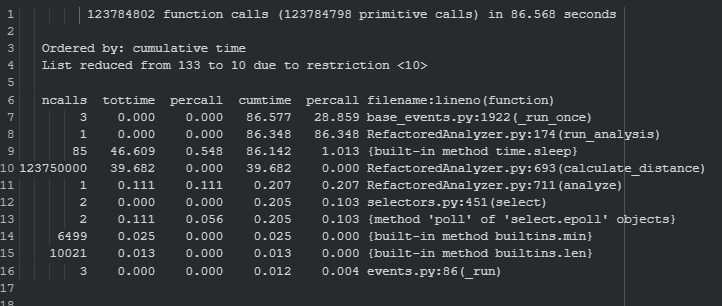


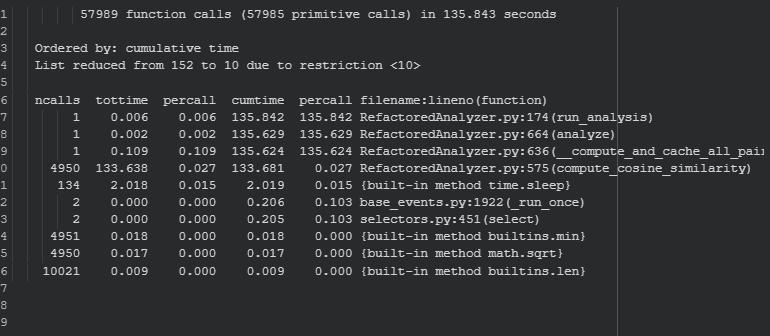




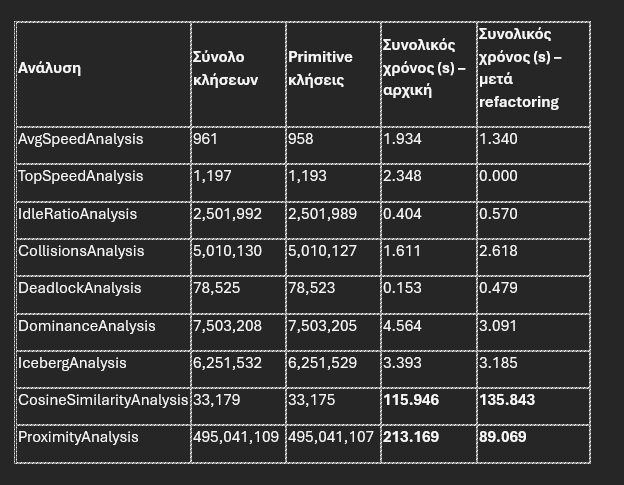

Αναφορικά με τις συγκεκριμένες μετρήσεις για τις υπόλοιπες αναλύσεις βλέπουμε ότι είναι περίπου ίδιες, κάποιες ελαφρώς βελτιωμένες και κάποιες πήραν λίγο περισσότερο χρόνο.

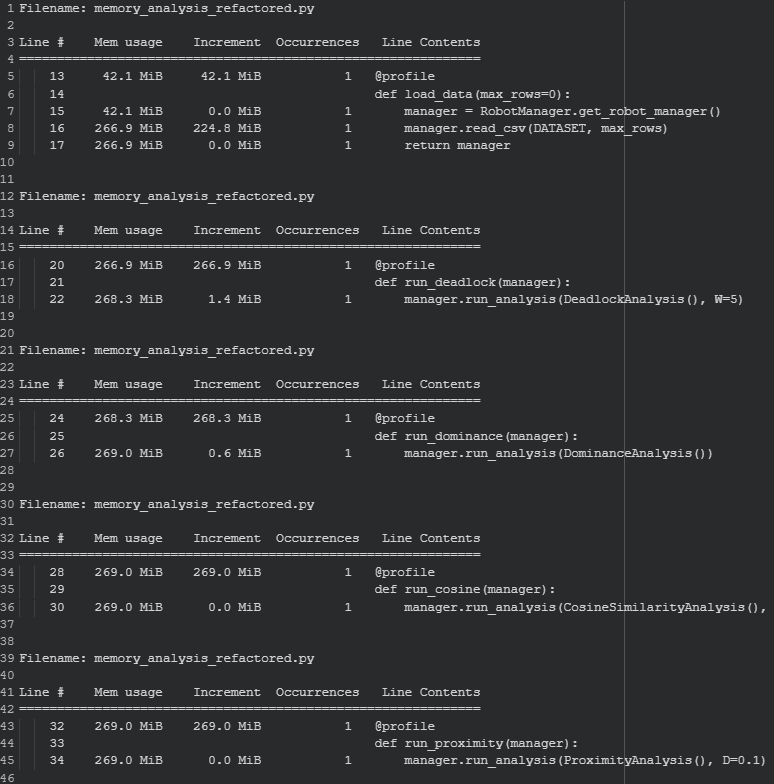

Αν και προσθέσαμε μηχανισμό caching, η χρήση μνήμης δεν αυξήθηκε, δίοτι το caching υλοποιήθηκε μέσω αρχείων CSV. Από ότι φαίνεται η αποθήκευση ενδιάμεσων αποτελεσμάτων που γίνεται μέσω της compute_average() είναι αμελητέο, καθώς δεν παρατηρείται κάποια αύξηση στην μνήμη.

# Unit Testing Phase

## ⏩ Κώδικας Unit Testing Phase

In [ ]:
%%file test_analyzer.py
import os
import csv
import shutil
import tempfile
import unittest
import Analyzer as RA


class TestAnalyzer(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        #temp directory creation
        cls.tmpdir = tempfile.mkdtemp(prefix="robot_tests_")
        cls.csv_path = os.path.join(cls.tmpdir, "robots.csv")

        with open(cls.csv_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([
                "robotID", "current_time", "current_time_step",
                "px", "py", "pz",
                "vx", "vy",
                "goal_status", "idle", "linear",
                "rotational", "deadlock", "body_contact"
            ])

            # ------------- ROBOT 1 -------------
            writer.writerow([1, 0.0, 0,
                             0, 0, 0,
                             0, 1,
                             "collision detected", "False", "True", "False",
                             "False", "False"])

            writer.writerow([1, 1.0, 1,
                             1, 0, 1,
                             1, 0,
                             "moving to station 3", "False", "False", "False",
                             "True", "False"])

            writer.writerow([1, 2.0, 2,
                             2, 1, 0,
                             0, 1,
                             "collision detected", "True", "False", "False",
                             "True", "False"])


            # ------------- ROBOT 2 -------------
            writer.writerow([2, 0.0, 0,
                             0, 0, 0,
                             1, 0,
                             "collision detected", "False", "False", "False",
                             "False", "False"])

            writer.writerow([2, 1.0, 1,
                             1, 1, 0,
                             0, 1,
                             "moving to station 3", "False", "False", "False",
                             "True", "False"])

            writer.writerow([2, 2.0, 2,
                             0, 2, 1,
                             1, 1,
                             "stopped (unknown)", "False", "False", "False",
                             "False", "False"])

        # Load robot data once for all tests
        cls.manager = RA.RobotManager.get_robot_manager()
        cls.manager.read_csv(cls.csv_path, 0)
        cls.robots = cls.manager.robots


    @classmethod
    def tearDownClass(cls):
        shutil.rmtree(cls.tmpdir, ignore_errors=True)

    def setUp(self):
        fd, self.log_path = tempfile.mkstemp(dir=self.tmpdir, prefix="run_", suffix=".log")
        os.close(fd)
        self.log = open(self.log_path, "w", encoding="utf-8")
        self.log.write("Starting test: %s\n" % self.id())
        self.log.flush()

        # Fresh local copy
        self.local_robots = self.robots.copy()

    def tearDown(self):
        if hasattr(self, "log") and not self.log.closed:
            self.log.write(f"Ending test: {self.id()}\n")
            self.log.close()

        if os.path.exists(self.log_path):
            print(open(self.log_path).read())
            os.remove(self.log_path)

    def test_csv_loaded(self):
        self.assertEqual(len(self.local_robots), 2)
        r1 = self.local_robots[1]
        r2 = self.local_robots[2]
        self.assertEqual(len(r1.positions), 3)
        self.assertEqual(r1.positions[1], (1.0, 0.0, 1.0))
        self.assertEqual(r1.goal_statuses[1], "moving to station 3")
        self.assertEqual(r2.positions[0], (0.0, 0.0, 0.0))
        self.assertEqual(r1.goal_statuses[2], "collision detected")
        self.assertEqual(r1.speeds[0], (0.0, 1.0))
        self.assertEqual(r1.speeds[1], (1.0, 0.0))
        self.assertIsInstance(r1.idle_flags[0], bool)
        self.assertEqual(r1.deadlock_flags, [False, True, True])
        self.assertEqual(r2.deadlock_flags, [False, True, False])



    def test_avg_speed(self):
        analysis = RA.AvgSpeedAnalysis()
        res = analysis.analyze(self.local_robots, v1=0, v2=10)
        self.assertIn(1, res)
        self.assertIn(2, res)
        #expected avg speed for robot 2 = 1.13807
        expected_avg1 = 1
        self.assertEqual(res[1]["avg_speed"], expected_avg1)
        #expected avg speed for robot 1 = 1
        expected_avg2 = 1.13807
        self.assertAlmostEqual(res[2]["avg_speed"], expected_avg2, places=5)


    def test_top_speed(self):
        analysis = RA.Top_speed_analysis()
        res = analysis.analyze(self.local_robots, k=2)
        self.assertEqual(len(res), 2)
        self.assertEqual(res[1]["rank"], 2)
        self.assertEqual(res[2]["rank"], 1)
        self.assertGreater(res[2]["avg_speed"], res[1]["avg_speed"])
        self.assertIn("rank", res[1])
        self.assertIn("samples", res[2])



    def test_idle_ratio(self):
        analysis = RA.Idle_ratio_analysis()
        res = analysis.analyze(self.local_robots, MIN=0, MAX=1)
        self.assertEqual(len(res), 2)
        #expected results: r1: 0.333,r2: 0
        self.assertAlmostEqual(res[1]["idle_ratio"], 0.333, places=3)
        self.assertEqual(res[2]["idle_ratio"], 0)
        self.assertEqual(res[1]["samples"], 3)
        self.assertEqual(res[2]["samples"], 3)

    def test_collision(self):
        analysis = RA.CollisionsAnalysis()
        res = analysis.analyze(self.local_robots, T1=0, T2=10)
        self.assertIn(2, res)
        self.assertIn(1, res)
        self.assertEqual(res[1]["count"], 2)
        self.assertEqual(res[2]["count"], 1)
        self.assertGreaterEqual(res[1]["T2"], res[1]["T1"])


    def test_deadlock(self):
        analysis = RA.DeadlockAnalysis()
        res = analysis.analyze(self.local_robots, W=0)
        self.assertIn(1, res)
        self.assertEqual(res[1][0]["len"], 2)
        self.assertEqual(res[2][0]["len"], 1)

    def test_dominance(self):
        analysis = RA.DominanceAnalysis()
        res = analysis.analyze(self.local_robots)
        self.assertEqual(res[2]["dominance_points"], 1)
        self.assertIn(1, res)

    def test_iceberg(self):
        analysis = RA.IcebergAnalysis()
        res = analysis.analyze(self.local_robots, K=0, S=0.05)
        self.assertTrue(len(res) >= 1)
        self.assertAlmostEqual(res[1]["mean displacement"], 1.4142, places=4)
        self.assertAlmostEqual(res[2]["mean displacement"], 1.5731, places=4)

    def test_cosine_similarity(self):
        analysis = RA.CosineSimilarityAnalysis()
        res = analysis.analyze(self.local_robots, THETA=0.01)
        self.assertIsInstance(res, list)
        self.assertEqual(len(res), 1)
        self.assertEqual(res[0]["robot_1"], 1)
        self.assertEqual(res[0]["robot_2"], 2)
        self.assertAlmostEqual(res[0]["cosine_similarity"], 0.2887, places=4)

    def test_proximity(self):
        analysis = RA.ProximityAnalysis()
        res = analysis.analyze(self.local_robots, D=10)
        self.assertGreater(len(res), 0)
        self.assertAlmostEqual(res[0]["distance"], 1.4142, places=4)
        self.assertAlmostEqual(res[1]["distance"], 2.4495, places=4)


    def test_log_file_was_created_and_removed(self):
        self.assertTrue(os.path.exists(self.log_path))
        self.assertFalse(self.log.closed)
        self.assertTrue(self.log_path.startswith(self.tmpdir))



if __name__ == "__main__":
  unittest.main(verbosity=2)

Overwriting test_analyzer.py


In [ ]:
!python -m unittest test_analyzer.py

Starting test: test_analyzer.TestAnalyzer.test_avg_speed
Ending test: test_analyzer.TestAnalyzer.test_avg_speed

.Starting test: test_analyzer.TestAnalyzer.test_collision
Ending test: test_analyzer.TestAnalyzer.test_collision

.Starting test: test_analyzer.TestAnalyzer.test_cosine_similarity
Ending test: test_analyzer.TestAnalyzer.test_cosine_similarity

.Starting test: test_analyzer.TestAnalyzer.test_csv_loaded
Ending test: test_analyzer.TestAnalyzer.test_csv_loaded

.Starting test: test_analyzer.TestAnalyzer.test_deadlock
Ending test: test_analyzer.TestAnalyzer.test_deadlock

.Starting test: test_analyzer.TestAnalyzer.test_dominance
Ending test: test_analyzer.TestAnalyzer.test_dominance

.Starting test: test_analyzer.TestAnalyzer.test_iceberg
Ending test: test_analyzer.TestAnalyzer.test_iceberg

.Starting test: test_analyzer.TestAnalyzer.test_idle_ratio
Ending test: test_analyzer.TestAnalyzer.test_idle_ratio

.Starting test: test_analyzer.TestAnalyzer.test_log_file_was_created_and_re

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Unit Testing Phase

In [ ]:
"""
Για την υλοποιηση του unit testing υλοποιήσαμε ενα σύνολο απο αυτόματους ελέγχους
(unit tests), τα οποία επιβεβαίωναν οτι κάθε επιμέρους υπολογισμός παράγει το αναμενόμενο
αποτέλεσμα και οτι η συνολική λειτουργία του συστήματος είναι σταθερή και ορθή. Στα διάφορα
test που δημιουργήσαμε, τεστάραμε την σωστη φόρτωση των δεδομένων με την δημιουργία ενός
προσωρινού(mock) CSV αρχείου, το οποίο περιλάμβανε 6 στιγμιότυπα για 2 ρομπότ, με τιμές
δεδομένων τέτοιες, έτσι ώστε να είναι πιο άνετη και απλή η διαδικασία των test. Επίσης,
δημιουργήσαμε και ένα προσωρινο log file, το οποίο δημιουργείται μεσα στην setUp(), και
διαγράφεται στην tearDown(), δείχνοντας οτι τα tests δεν αφήνουν υπολλειματα στο σύστημα.
Τα σφάλματα των tests εμφανίζονται μόνο μέσω των assertions του unit test και οχι στo log file.
Στην setUp δημιουργούμε ενα local αντίγραφο των ρομπότ, έτσι ωστε κάθε τεστ να είναι
ανεξάρτητο και να μην υπάρχει περίπτωση να επηρεαστεί από αλλαγές προηγουμένων τεστ.
Στη συνέχεια, ελέγξαμε οτι τα συμπεράσματα των αναλύσεων ήταν τα ίδια με αυτα που υπολογίσαμε
θεωρητικά και οτι τα δεδομένα φορτωνόντουσαν σωστα στο προγραμμα. Όλη η παραπάνω διαδικασία
υλοποιήθηκε βάσει του παραδείγματος pricing system που αναλύθηκε στα πλαίσια των διαλέξεων.
"""

Καλή Δουλειά!
